# Project_2_finsleep_waves

Wczytuję badany sygnał EEG i sprawdzam jego przebieg

In [4]:
%matplotlib inline
import matplotlib

matplotlib.rcParams['figure.figsize'] = (12,10)
matplotlib.rcParams.update({'font.family': 'Arial'})
matplotlib.rcParams.update({'font.size': 10})

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import scipy.signal as ss
import matplotlib.pylab as plt

/work/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


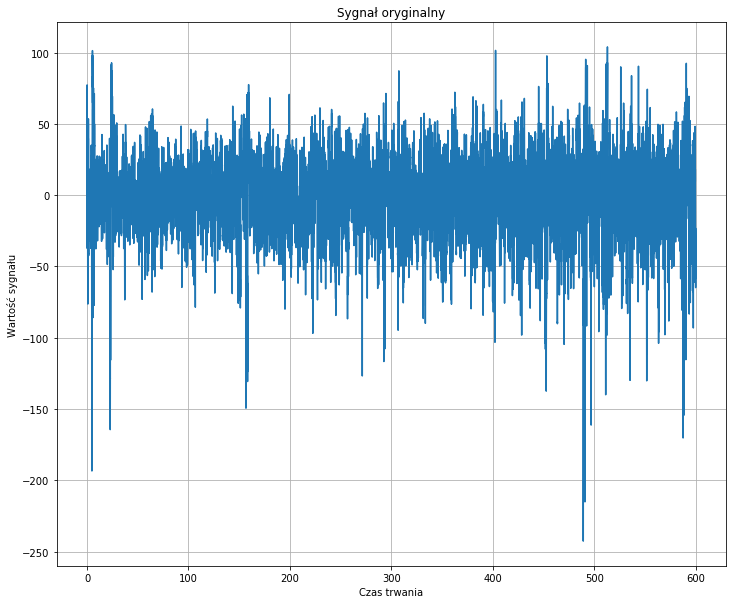

In [5]:
s = np.fromfile('inb14_fragment.bin',dtype = 'float32')
Fs = 128
t = np.arange(0,len(s))/Fs
plt.figure()
plt.plot(t,s, label='syngał oryginalny')
plt.title ("Sygnał oryginalny")
plt.xlabel('Czas trwania')
plt.ylabel('Wartość sygnału')
plt.grid('on')
plt.show()

### Pierwszy klasyfikator

Badany sygnał filtruję przy użyciu filtra pasmowo - przepustowego w paśmie 11-16 Hz i odpowiednio przekształcam. Następnie wyszukuję fragmenty, w których sygnał przekracza 5 mikroVoltów na okresy dłuższe niż 0.5 s, oznaczając te fragmenty jako poszukiwane przez nas wrzeciona snu.

/work/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


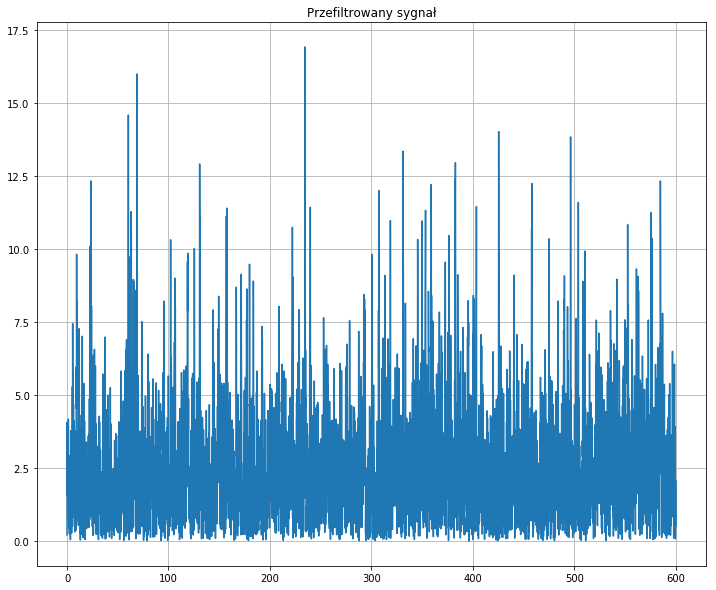

In [6]:
from  scipy.signal import firwin, lfilter, butter, filtfilt

#filtruję sygnał filtrem pasmowo - przepustowym
[bl,al] = butter(8,[11/(Fs/2),16/(Fs/2)],btype = 'bandpass')
sf_1 = filtfilt(bl,al,s)

sf_1_2 = sf_1**2 #podnoszę sygnał od kwadratu

#ponownie filtruję sygnał, tym razem filtrem dolnoprzepustowym z częstością odcięcia 10 Hz
[b,a] = butter(8, [10/(Fs/2)], btype='lowpass') 
sf_2 = filtfilt(b,a,sf_1_2)

#pierwiastkuję usyskany sygnał

sf_2_2 = np.abs(sf_2)
signal = np.sqrt(sf_2_2)
plt.plot(t, signal)
plt.title("Przefiltrowany sygnał")
plt.grid('on')
plt.show()


In [7]:
wrzeciona = [] 
poczatek_czasu = 0
poczatek_wrzeciona = 0

for i in range(len(signal)):  #szukamy momentów sygnału, gdzie ten przekracza 5 mikrovoltów, jeżeli tak jest oznaczamy czas w którym go znaleźliśmy jako "i", zaczynamy odliczanie i sprawdzamy przez jak długo utrzyma się wartość sygnału >5
    if signal[i]>=5:
        if poczatek_wrzeciona == 0:
            poczatek_czasu = i
            poczatek_wrzeciona = 1
    else:
        if i - poczatek_czasu >=64: #szukamy przynajmniej okresu trwającego 0,5s, czyli 64 próbki -> próbkujemy z częstością Fs = 128, zatem 1s odpowiada 128 próbkom.
            wrzeciona.append((poczatek_czasu,i)) #dodajemy przedziały czasowe w których występują wrzeciona
            poczatek_czasu = i
            poczatek_wrzeciona = 0  #po zapisaniu przedziału wracamy do warunków początkowych, aby móc powtórzyć całą procedurę z kolejnymi próbkami
        else: 
            poczatek_czasu = i
            poczatek_wrzeciona = 0 #jeżeli odległość jest mniesza niż 64 nie spełnia warunków wrzeciona, odrzucamy zakres i zaczynamy od nowa
    
print ("Ilość wrzecion:", len(wrzeciona))
print("Przedziały czasowe, w których istnieją wrzeciona:",wrzeciona)
            

Ilość wrzecion: 22
Przedziały czasowe, w których istnieją wrzeciona: [(1194, 1267), (13110, 13176), (15165, 15253), (16711, 16791), (28392, 28457), (39280, 39392), (42359, 42449), (45149, 45257), (45583, 45662), (45898, 46000), (47191, 47258), (48931, 49044), (49931, 49996), (50608, 50678), (54439, 54520), (58598, 58666), (62708, 62779), (64466, 64534), (65056, 65120), (69362, 69431), (70679, 70752), (74835, 74945)]


### Drugi klasyfikator

Wykonujemy dekompozycje MP dla podzielonego na fragmenty sygnału i na ich podstawie wykonujemy mapy czas - częstość z zaznaczonymi fragmentami, gdzie widoczne są wrzeciona snu. Na początku przyjmujemy 30 epok, 50 iteracji, procent energii 95% i "energyError" = 0.1

Przygotowuję funkcje pomocnicze

In [26]:
def parametry_atomu(book, atom):
    f_Hz  = atom['params']['f']*book.fs/2    # przekodowujemy częstość atomu na częstość w Hz
    A     = atom['params']['amplitude']      # odczytujemy amplitudę
    faza  = atom['params']['phase']          # odczytujemy fazę
    t0    = atom['params']['t']/book.fs       # przeliczamy pozycję atomu z wartości w próbkach na wartości w sek.
    skala = atom['params']['scale']/book.fs 
    return f_Hz, A, faza, t0, skala  

def rekonstrukcja_atomu(book, atom):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)     
    rekonstrukcja = A * np.exp(-np.pi*((t-t0)/skala)**2)*np.cos(2*np.pi*f_Hz*(t-t0)+faza) # obliczamy przebieg czasowy atomu (funkcja Gabora) i 
    return t, rekonstrukcja

def tfr_atomu(book, atom, N_czestosci):
    f_Hz, A, faza, t0, skala = parametry_atomu(book, atom)
    t = np.arange(0,book.epoch_s/book.fs,1/book.fs)
    f = np.linspace(0, Fs / 2, N_czestosci)
    rec_t = np.zeros((1,book.epoch_s))
    rec_f = np.zeros((N_czestosci,1))
    rec_t[0,:] = np.exp(-np.pi*((t-t0)/skala)**2)     # obliczamy obwiednię czasową -> dla f. Gabora jest to f. Gaussa
    rec_f[:,0] = np.exp(-np.pi*((f-f_Hz)*skala)**2)   # obliczamy obwiednię częstotliwościową -> dla f. Gabora jest to f. Gaussa
    tfr_atom = np.kron(rec_t,rec_f) # przemnażamy przez siebie obwiednie -> to jest reprezentacja czas-częstość pojedynczego atomu
    tfr_atom/= np.sum(np.sum(tfr_atom))  # normalizujemy
    tfr_atom *= atom['params']['modulus']**2 # skalujemy energię
    return t, f, tfr_atom

def TFRPlot(TFR, t_mapy, f_mapy, sig, Fs=128,title =''):
    '''
    Funkcja do rysowania map czas-częstość z sygnałem zaprezentowanym poniżej
    TFR - mapa czas-częstość (time-freqyency representation
    t_mapy, f_mapy - wektory reprezentujące osie czasu i częstości
    sig - sygnał do wyrysowania pod mapą (np. ten, z którego powstała mapa)
    Fs - częstość próbkowania sygnału 
    title - tytuł do wyświetlenia ponad mapą
    '''
    df = f_mapy[1]-f_mapy[0]
    dt = t_mapy[1]-t_mapy[0]
    t = np.arange(0,len(sig))/Fs
    sygAxes = py.axes([0.05, 0.05, 0.8, 0.1])
    tfAxes = py.axes([0.05, 0.15, 0.8, 0.8])
    sygAxes.plot(t,sig)
    py.xlim((t_mapy.min(), t_mapy.max()))
    py.ylim((0,t_mapy.max()))
    #py.setp(sygAxes, yticklabels=[])
    tfAxes.imshow(TFR,aspect='auto',origin='lower',interpolation='nearest', 
                  extent=(t_mapy.min()-dt/2,t_mapy.max()+dt/2,f_mapy.min()-df/2,f_mapy.max()+df/2))
    py.setp(tfAxes,xticklabels=[])
    py.title(title)
    py.show()

Szykuję sygnał do dekompozycji

In [29]:
PlikKonfigu = 'inb14_fragment_1.set'
PlikSygnalu = 'inb14_fragment_01.bin'
Fs = 128
liczbaProbek_w_Epoce = len(s)/30 #badamy 30 epok
liczbaKanalow = 1
wybraneKanaly = 1
wybraneEpoki = '1-30'
typSlownika = 'OCTAVE_FIXED'
maxIteracji = 50
procentEnergii = 95.0 #podajemy w procentach
algorytm = 'SMP'

fo = open(PlikKonfigu, "wt")
fo.write( '# OBLIGATORY PARAMETERS\n')
fo.write( 'nameOfDataFile  ' + PlikSygnalu + '\n')
fo.write( 'nameOfOutputDirectory  ./\n')
fo.write( 'writingMode            CREATE \n') # 
fo.write( 'samplingFrequency      ' + str(Fs)+ '\n')
fo.write( 'numberOfChannels       ' + str(liczbaKanalow) + '\n')
fo.write( 'selectedChannels       ' + str(wybraneKanaly) + '\n')
fo.write( 'numberOfSamplesInEpoch ' + str(liczbaProbek_w_Epoce)+ '\n')
fo.write( 'selectedEpochs         ' + str(wybraneEpoki) + '\n')
fo.write( 'typeOfDictionary       ' + typSlownika +'\n')
fo.write( 'energyError            0.1 100.0 \n') #gęstość słownika,
fo.write( 'randomSeed             auto \n')
fo.write( 'reinitDictionary       NO_REINIT_AT_ALL \n')
fo.write( 'maximalNumberOfIterations ' +str(maxIteracji)+ '\n')
fo.write( 'energyPercent             ' +str(procentEnergii)+ '\n')
fo.write( 'MP                        ' + algorytm + '\n')
fo.write( 'scaleToPeriodFactor       1.0 \n')
fo.write( 'pointsPerMicrovolt        1.0 \n')

fo.write( '\n# ADDITIONAL PARAMETERS\n')
fo.write( 'normType                  L2 \n')
fo.write( 'diracInDictionary         YES \n')
fo.write( 'gaussInDictionary         YES \n')
fo.write( 'sinCosInDictionary        YES \n')
fo.write( 'gaborInDictionary         YES \n')
fo.write( 'progressBar               YES \n')
fo.close()

In [30]:
import os
os.system('./empi ' + PlikKonfigu)

0

Analogicznie dla "energyError" = 0.01

In [20]:
PlikKonfigu = 'inb14_fragment_2.set'
PlikSygnalu = 'inb14_fragment_001.bin'
Fs = 128
liczbaProbek_w_Epoce = len(s)/30 #badamy 30 epok
liczbaKanalow = 1
wybraneKanaly = 1
wybraneEpoki = '1-30'
typSlownika = 'OCTAVE_FIXED'
maxIteracji = 50
procentEnergii = 95.0 #podajemy w procentach
algorytm = 'SMP'

fo = open(PlikKonfigu, "wt")
fo.write( '# OBLIGATORY PARAMETERS\n')
fo.write( 'nameOfDataFile  ' + PlikSygnalu + '\n')
fo.write( 'nameOfOutputDirectory  ./\n')
fo.write( 'writingMode            CREATE \n') # 
fo.write( 'samplingFrequency      ' + str(Fs)+ '\n')
fo.write( 'numberOfChannels       ' + str(liczbaKanalow) + '\n')
fo.write( 'selectedChannels       ' + str(wybraneKanaly) + '\n')
fo.write( 'numberOfSamplesInEpoch ' + str(liczbaProbek_w_Epoce)+ '\n')
fo.write( 'selectedEpochs         ' + str(wybraneEpoki) + '\n')
fo.write( 'typeOfDictionary       ' + typSlownika +'\n')
fo.write( 'energyError            0.01 100.0 \n') #gęstość słownika,
fo.write( 'randomSeed             auto \n')
fo.write( 'reinitDictionary       NO_REINIT_AT_ALL \n')
fo.write( 'maximalNumberOfIterations ' +str(maxIteracji)+ '\n')
fo.write( 'energyPercent             ' +str(procentEnergii)+ '\n')
fo.write( 'MP                        ' + algorytm + '\n')
fo.write( 'scaleToPeriodFactor       1.0 \n')
fo.write( 'pointsPerMicrovolt        1.0 \n')

fo.write( '\n# ADDITIONAL PARAMETERS\n')
fo.write( 'normType                  L2 \n')
fo.write( 'diracInDictionary         YES \n')
fo.write( 'gaussInDictionary         YES \n')
fo.write( 'sinCosInDictionary        YES \n')
fo.write( 'gaborInDictionary         YES \n')
fo.write( 'progressBar               YES \n')
fo.close()

In [17]:
import os
os.system('./empi ' + PlikKonfigu)

0

Wytwarzam mapy czas-częstość na podstawie powyższych dekompozycji dla wszystkich 30 epok dla energyError = 0.1.

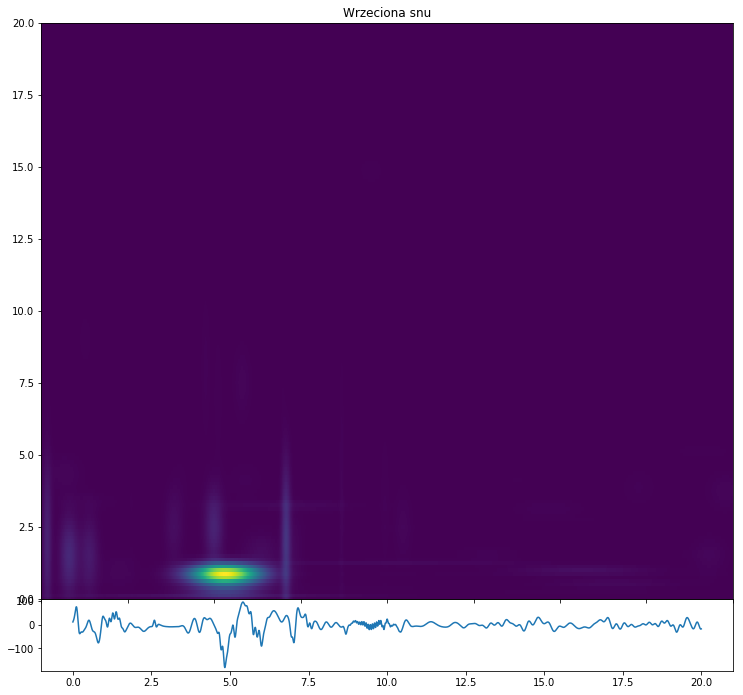

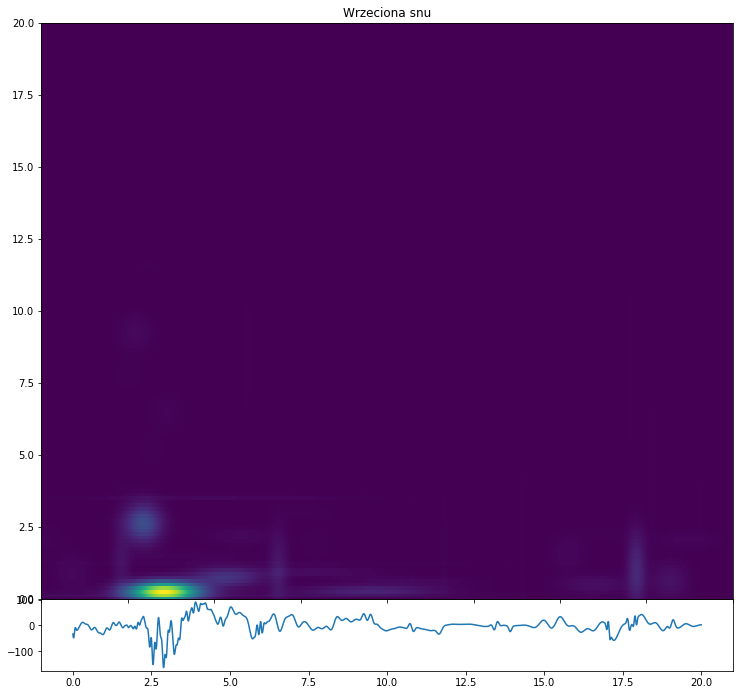

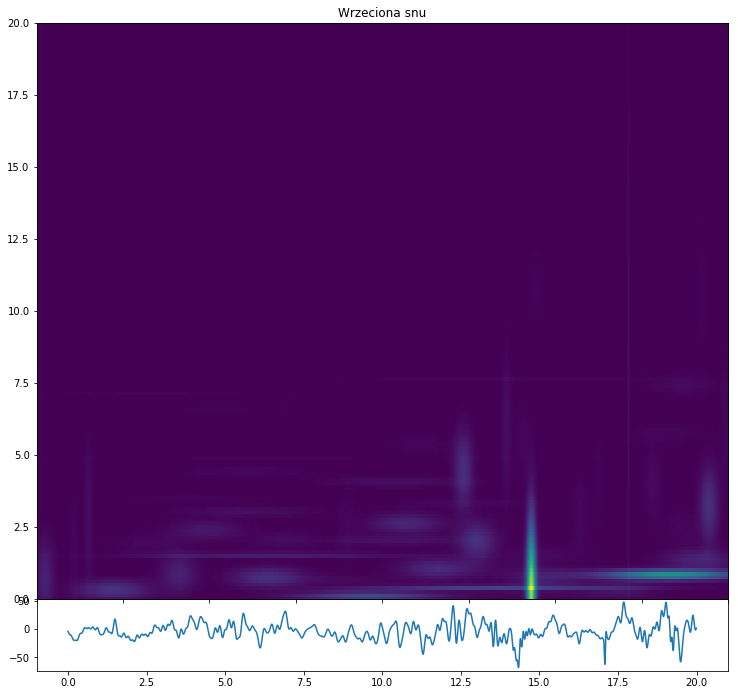

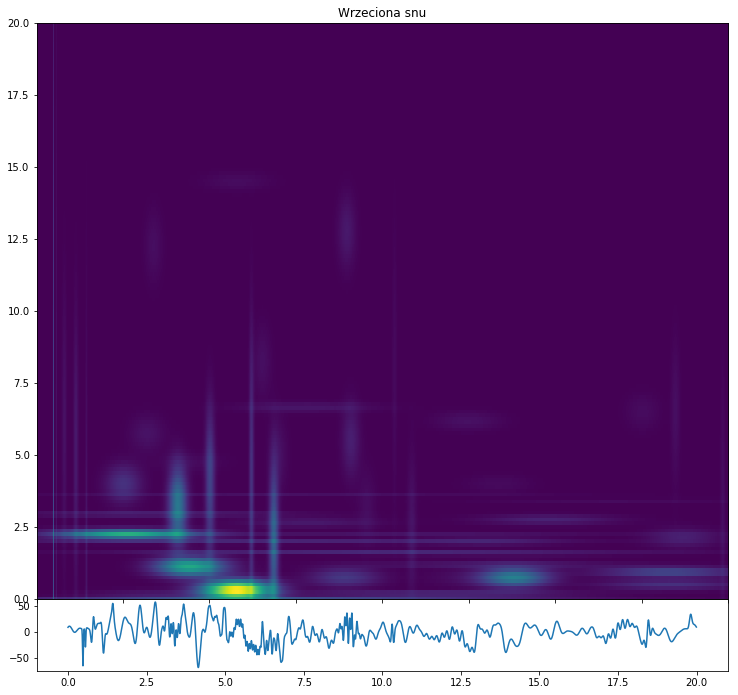

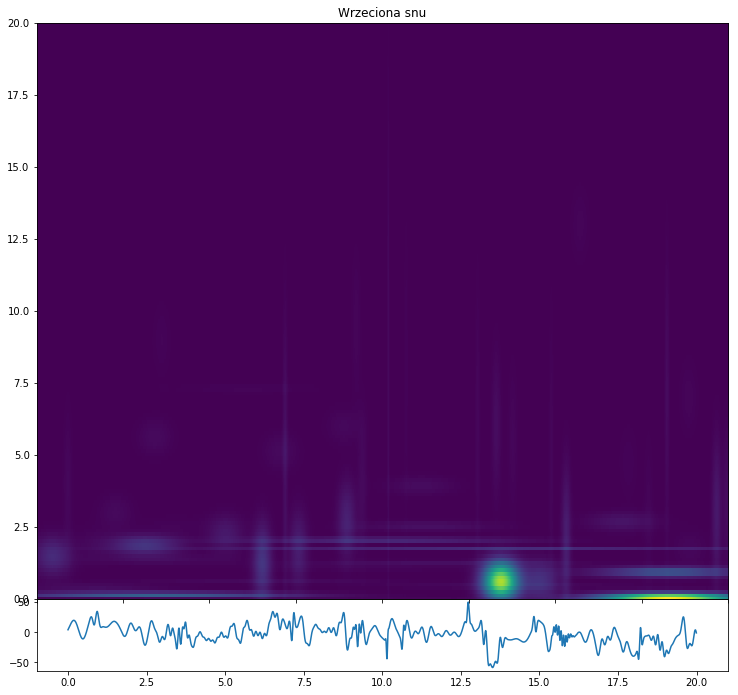

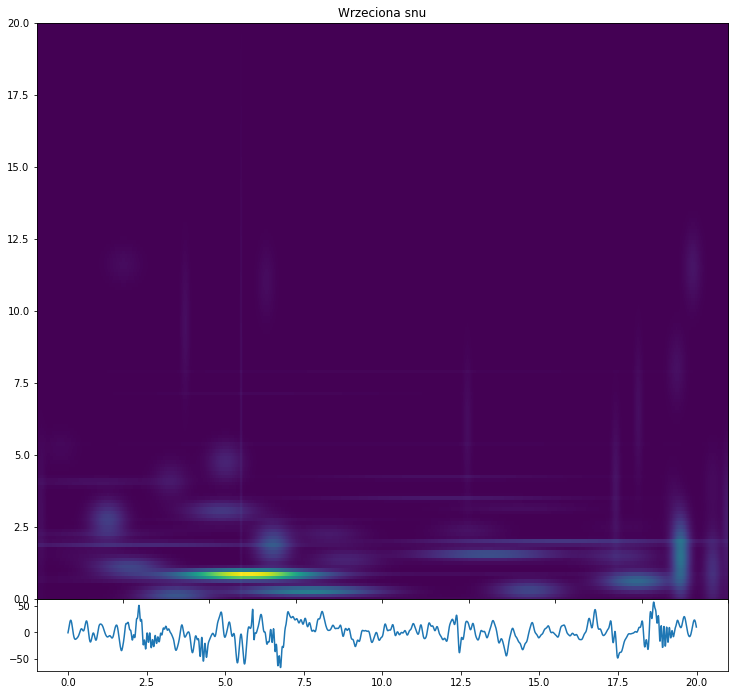

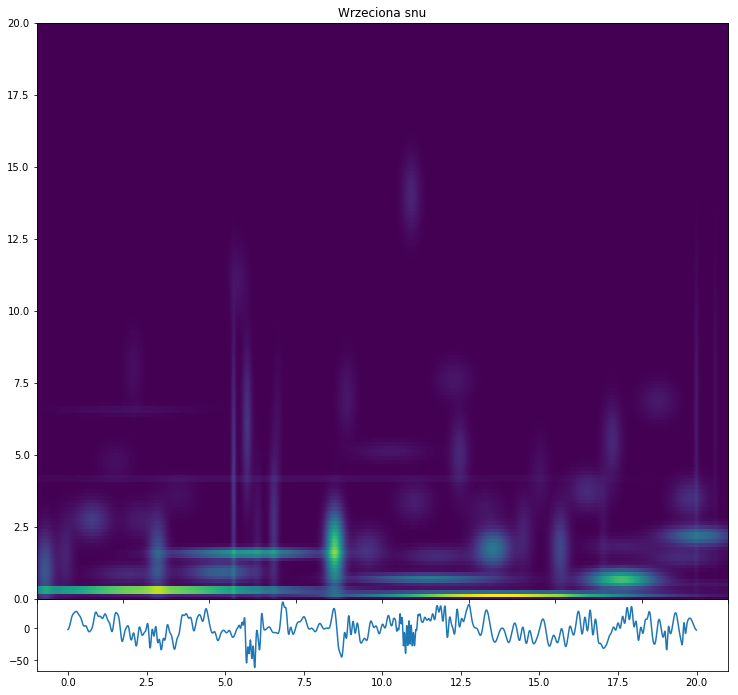

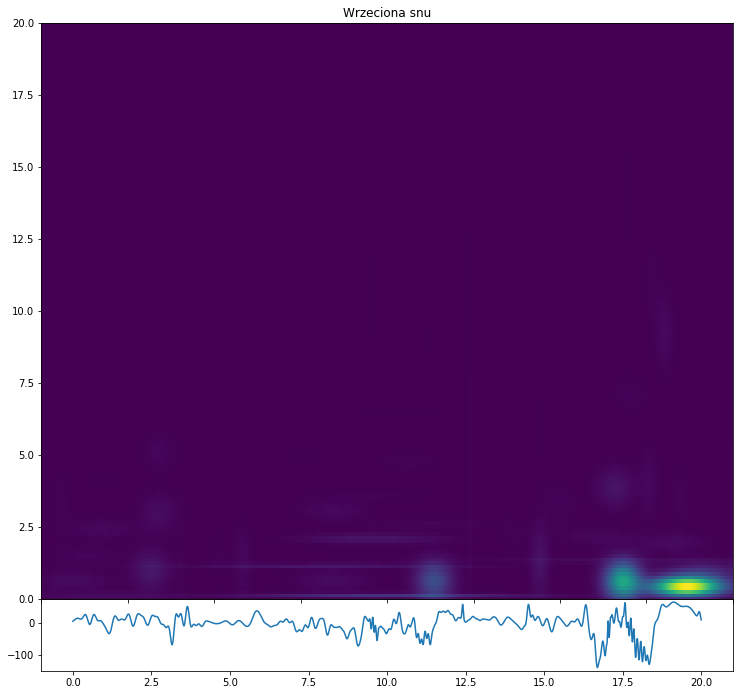

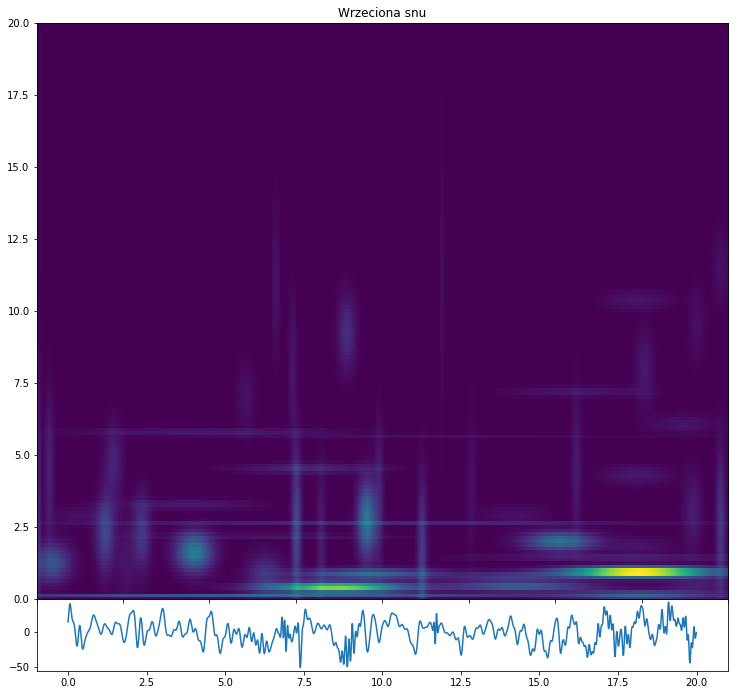

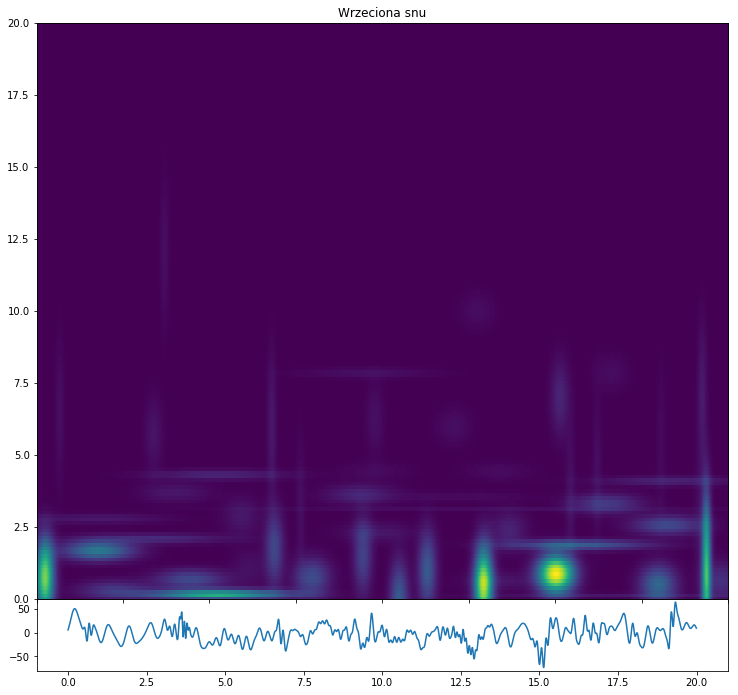

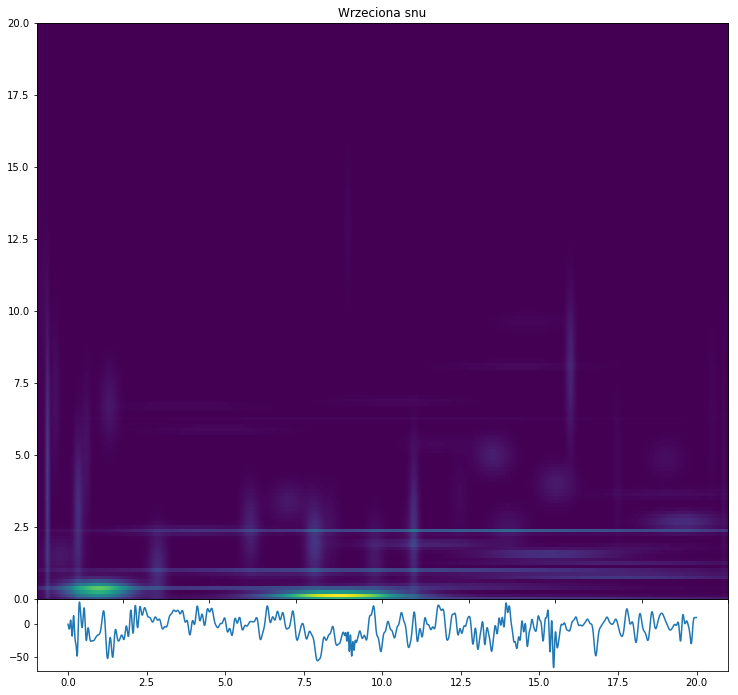

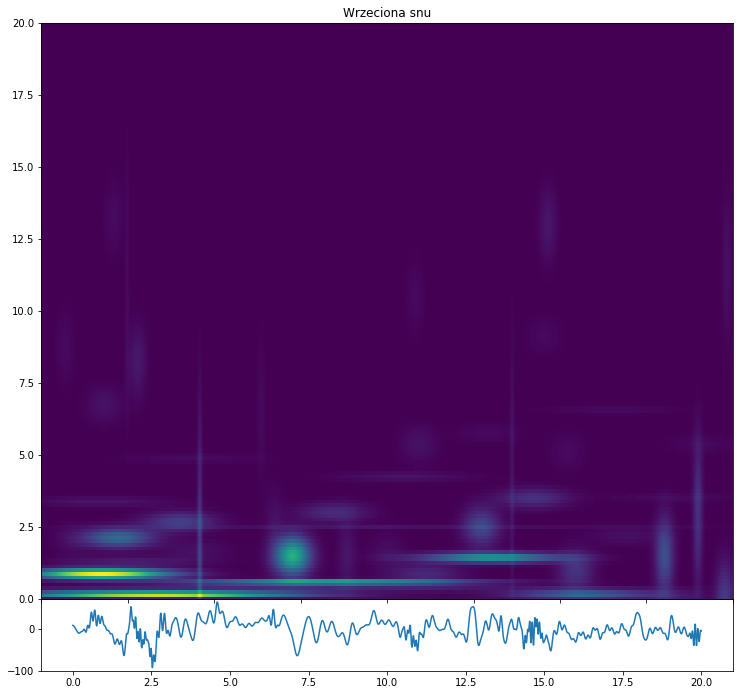

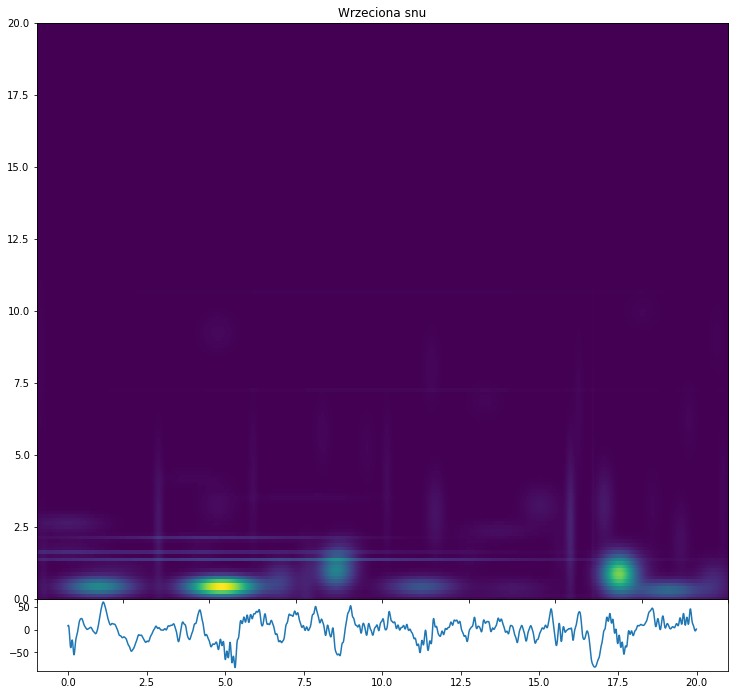

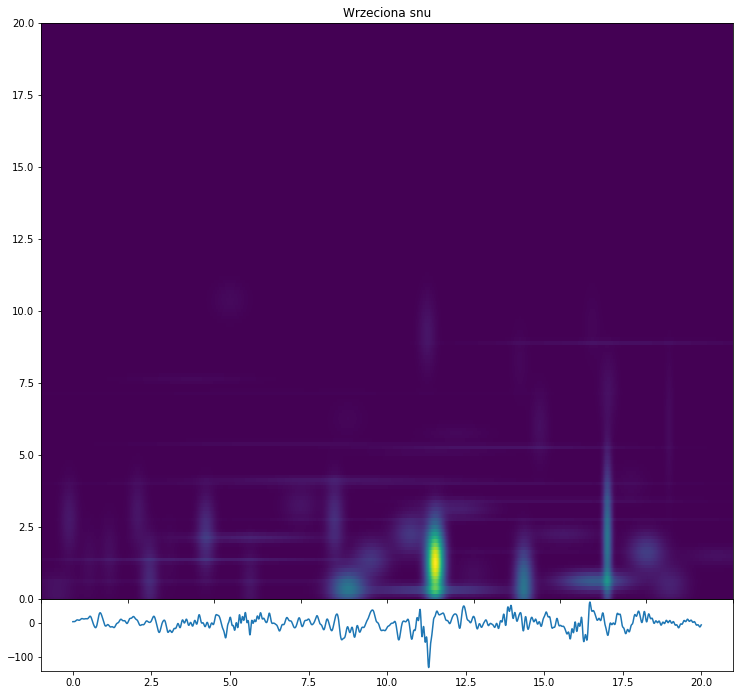

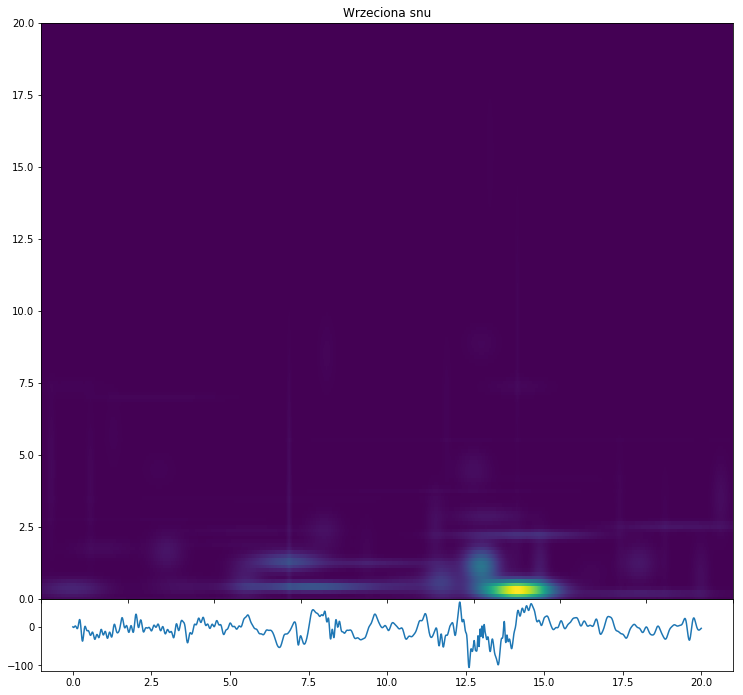

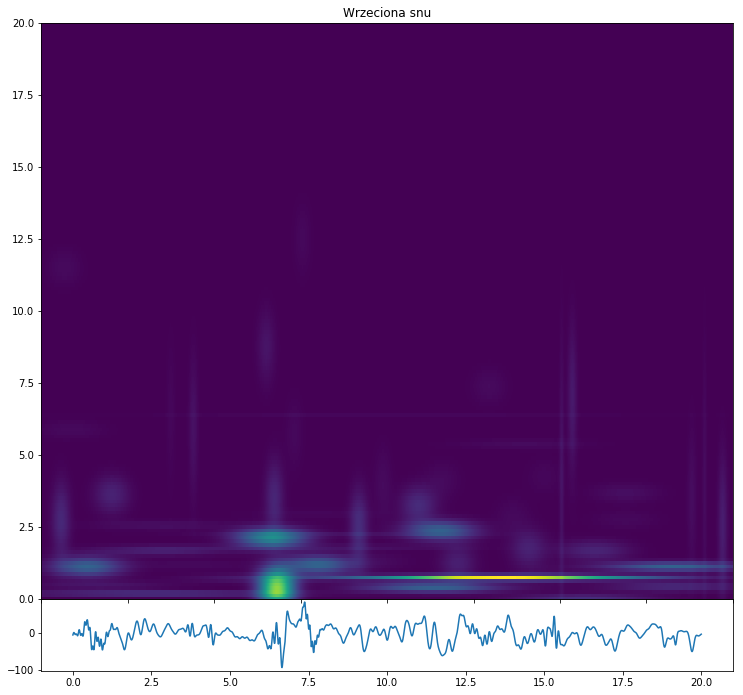

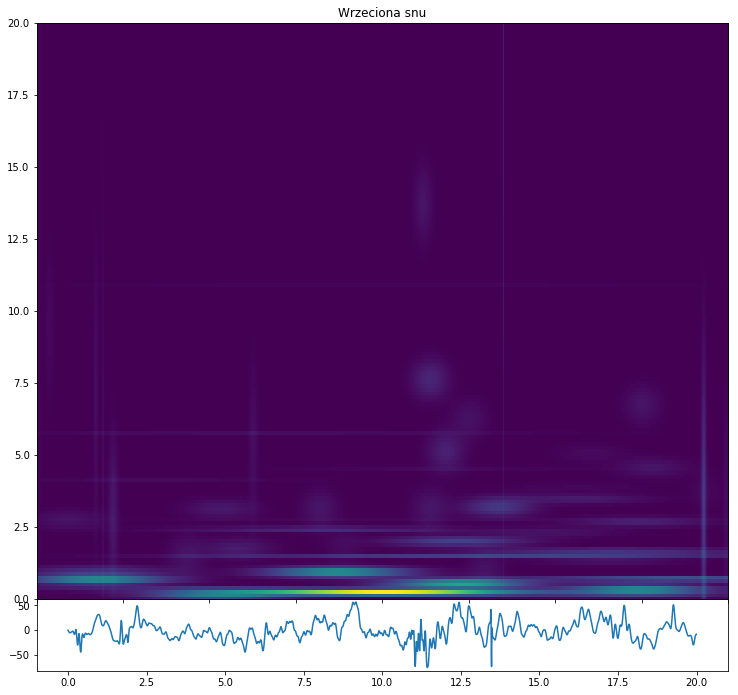

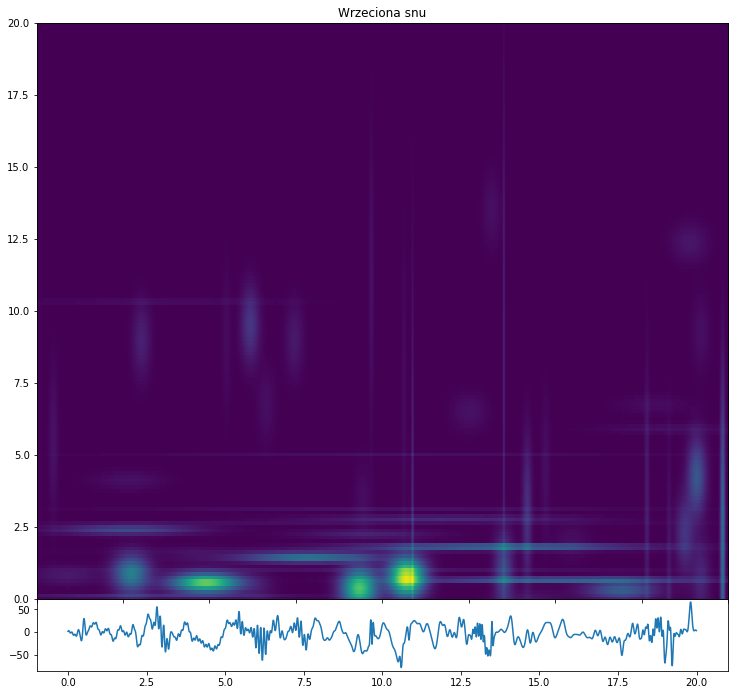

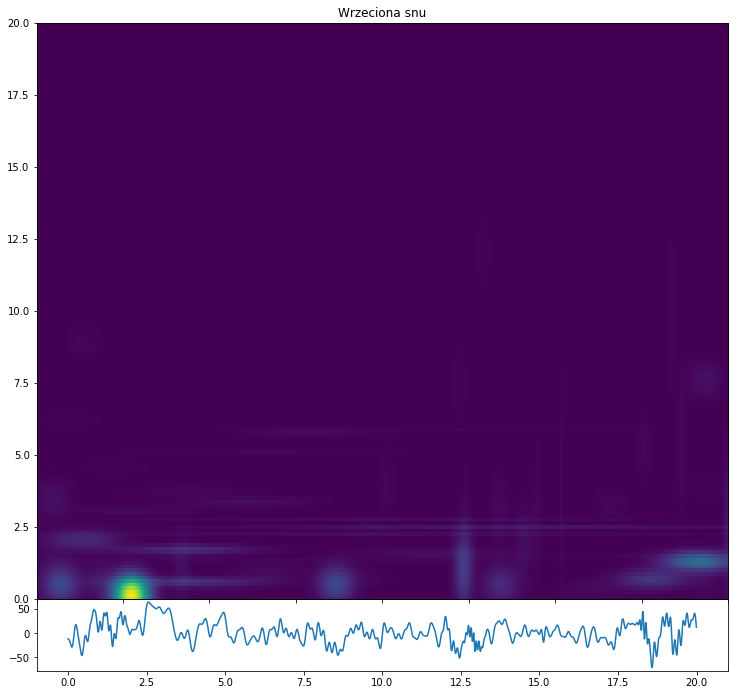

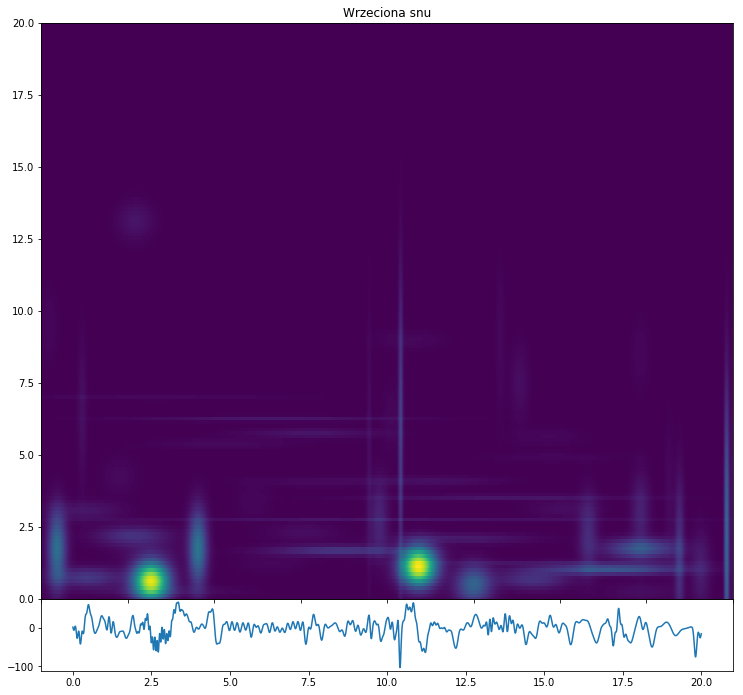

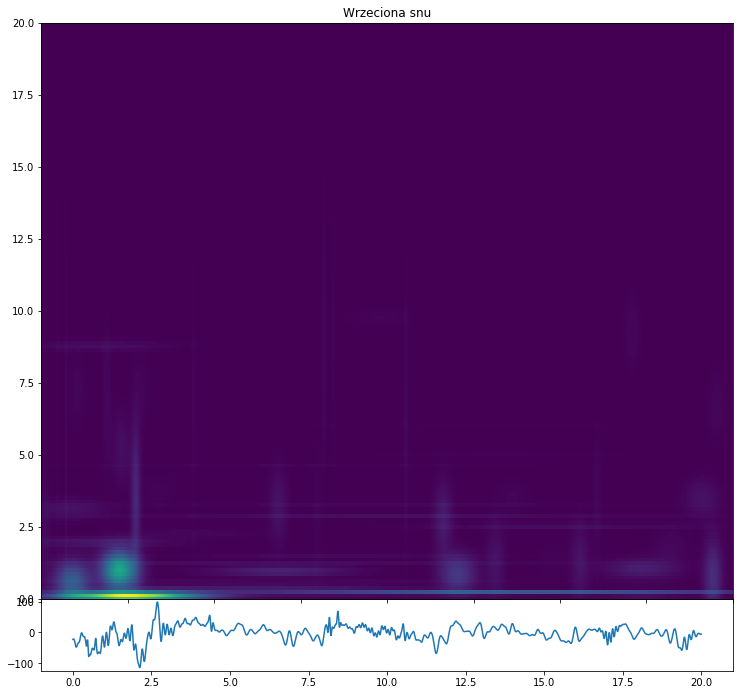

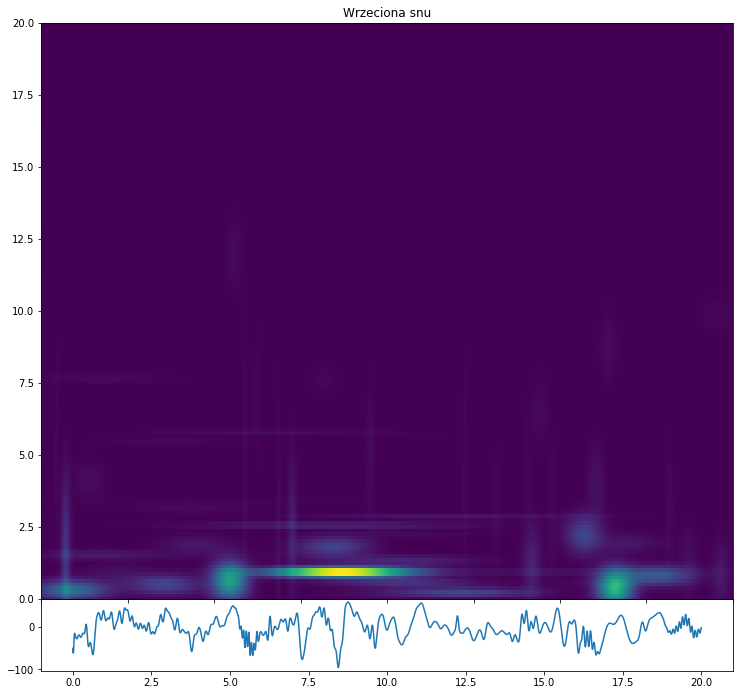

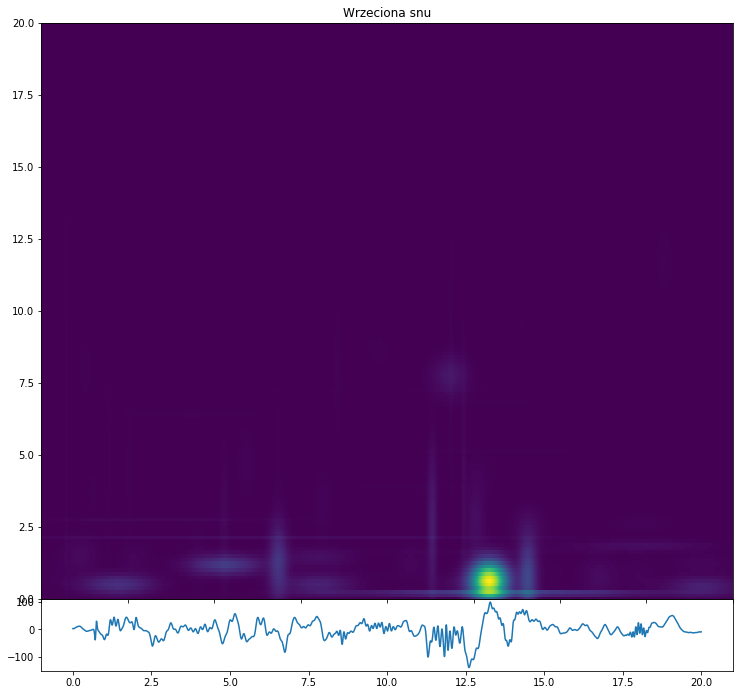

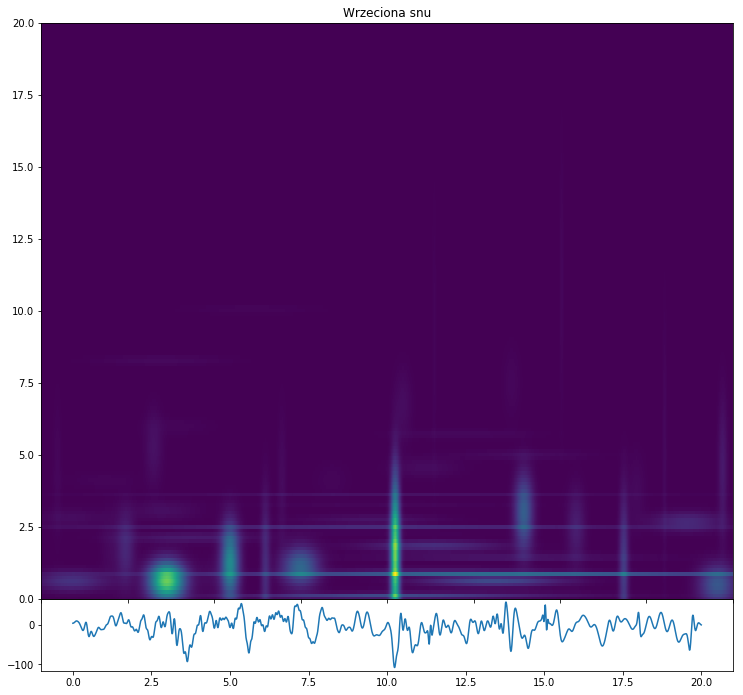

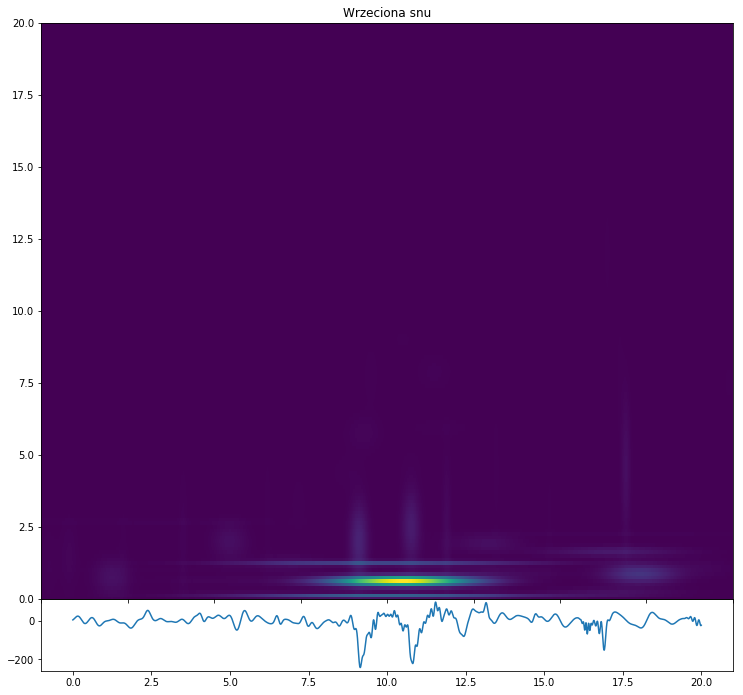

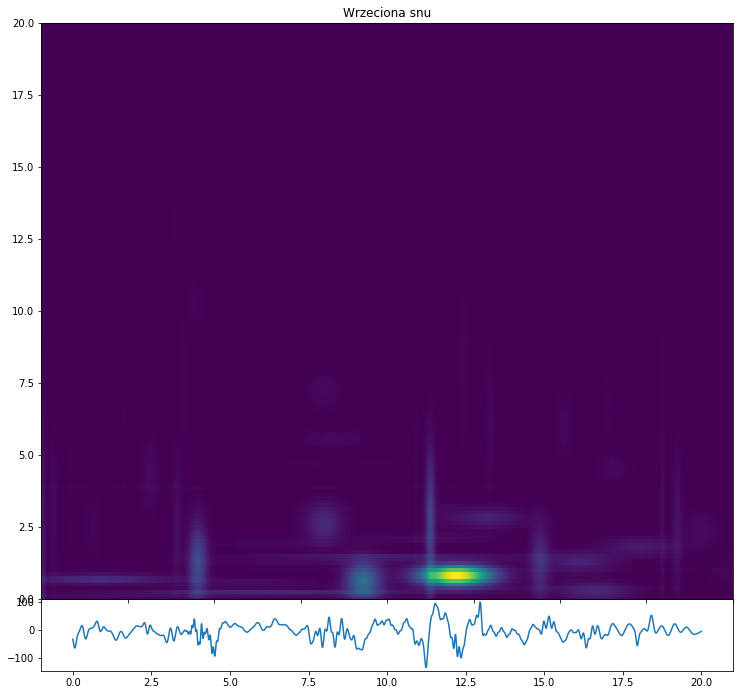

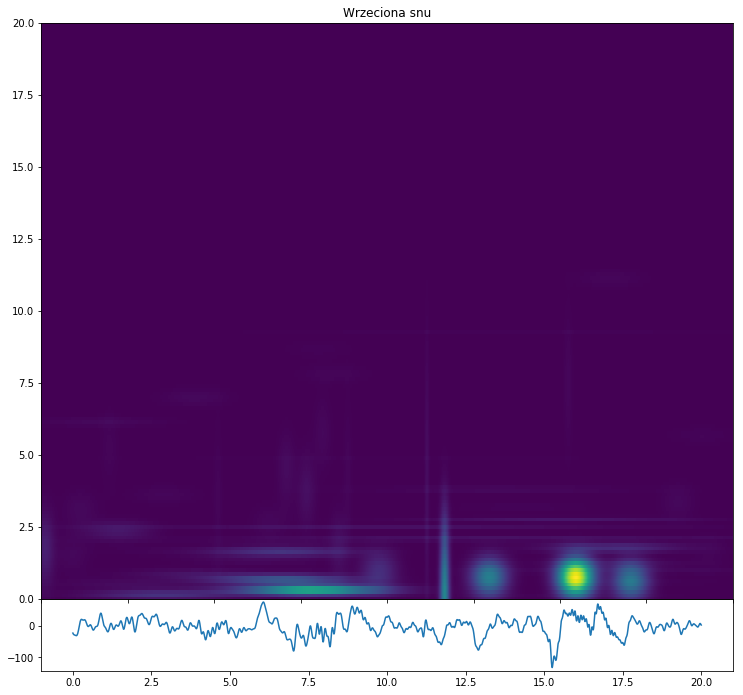

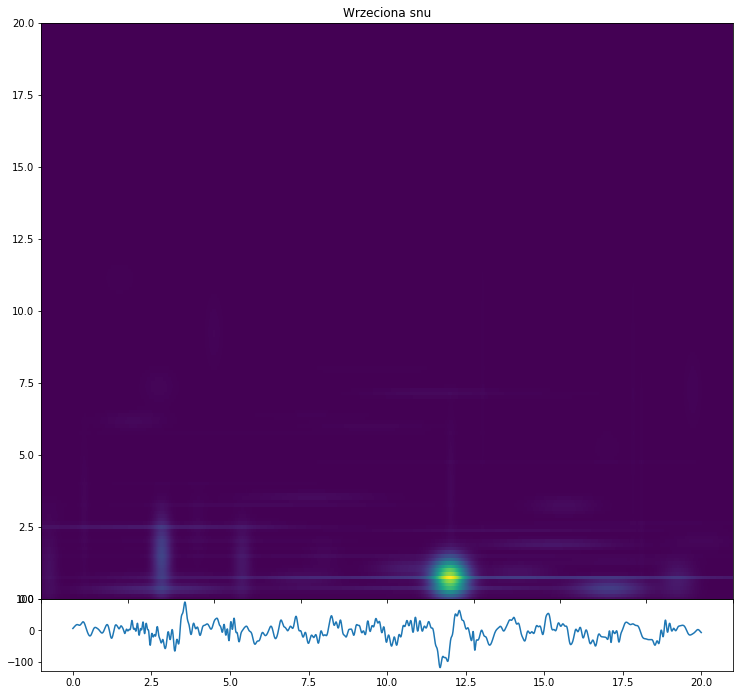

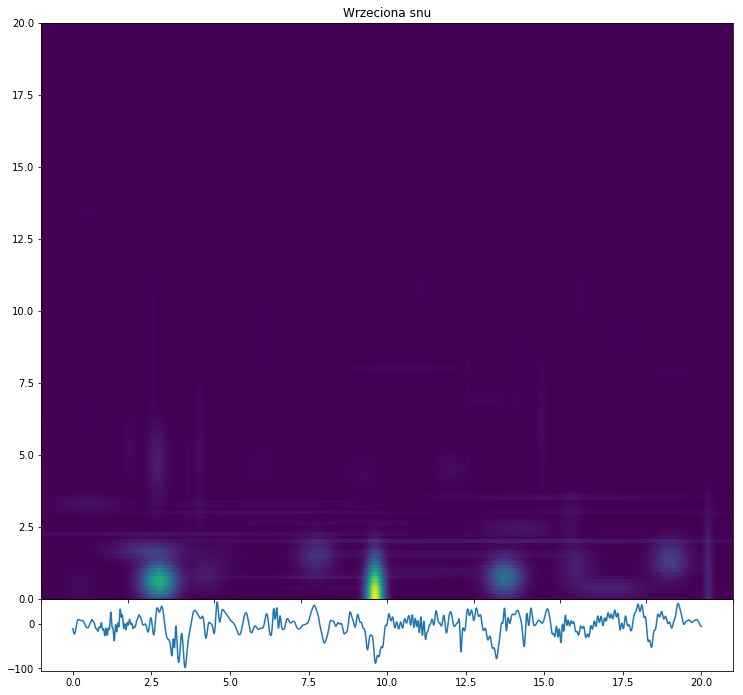

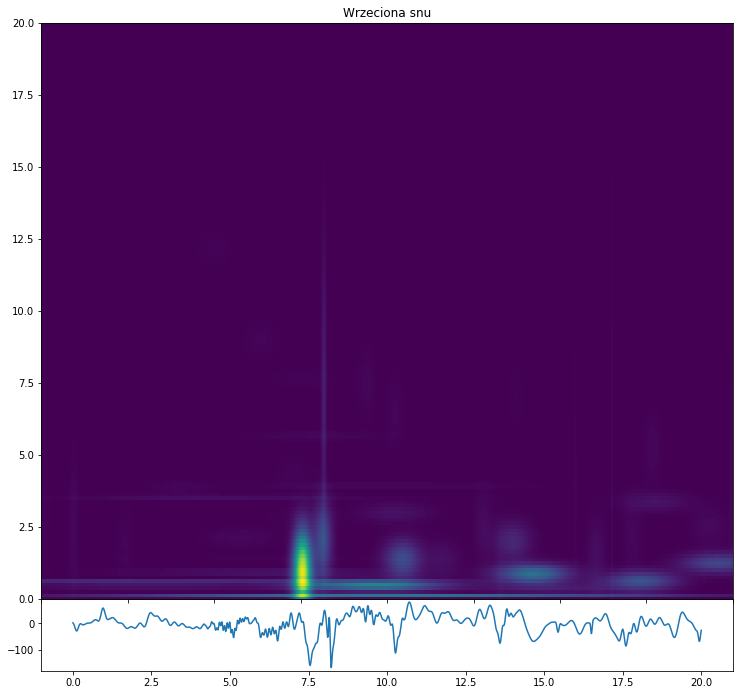

Liczba wrzecion snu: 4316
Liczba wrzecion snu: 4316


In [34]:
from book_reader import *


for i in range(1,31): # iterujemy się po epokach:  
    bookName = 'inb14_fragment_smp_1.b'
    book = BookImporter(bookName)

    rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
    N_czestosci = 512
    mapaEnergii = np.zeros((N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.



    numerEpoki = i                           # Posłuży on nam do odtwarzania poszczególnych atomów, liczymy je od 1, nie od 0 jak indeksy w Pythonie
    for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
        f_Hz, A, faza, t0, skala  =  parametry_atomu(book, atom)
        t, atom_czas = rekonstrukcja_atomu(book, atom)
        t, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
        mapaEnergii += atom_tfr
        rekonstrukcja += atom_czas
        liczba_wrzecion +=1
    TFRPlot(mapaEnergii, t, f, rekonstrukcja, Fs=128,title ='Wrzeciona snu') 




Przeglądam parametry atomow, sprawdzając, które z nich można zaklasyfikować, jako wrzeciona snu.

In [48]:
przedzialy_czasowe=[] #dokładamy analogicznie jak w pierwszym klasyfikatorze
liczba_wrzecion=0

for i in range(1,31):
    bookName = 'inb14_fragment_smp_1.b'
    book = BookImporter(bookName)

    numerEpoki = i
    for atom in book.atoms[numerEpoki]:
        f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
        if (f_Hz>=11)&(f_Hz<=14)&(skala*2>=0.5):
            liczba_wrzecion+=1
            przedzialy_czasowe.append(((i-1)*20 + t0, (i-1)*20 + t0 + skala)) #po 20s na epokę
print("Liczba wrzecion:", liczba_wrzecion)

Liczba wrzecion: 27


Powtarzam dla "energyError" = 0.01

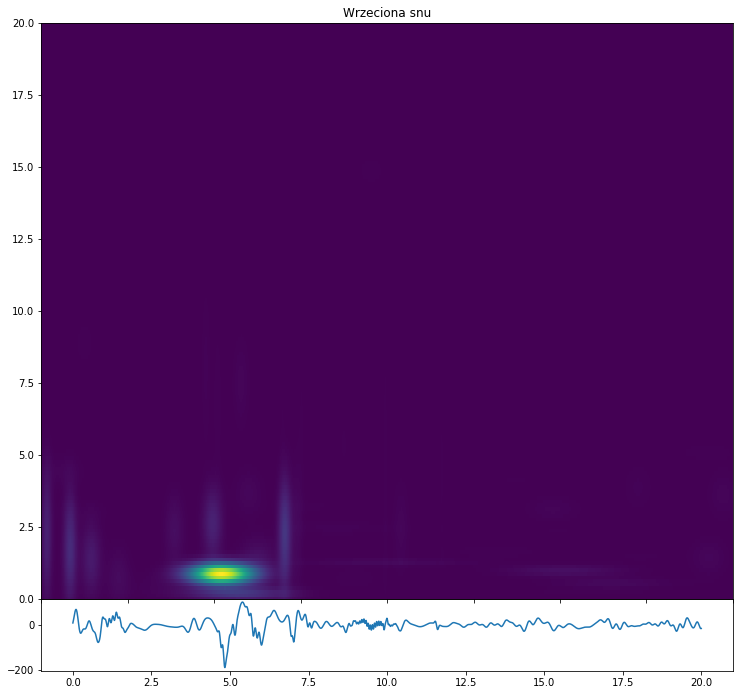

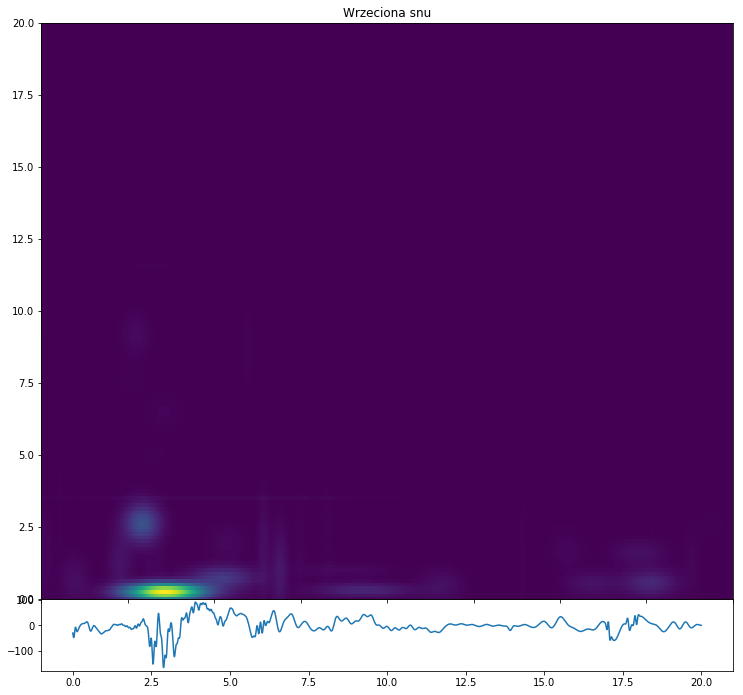

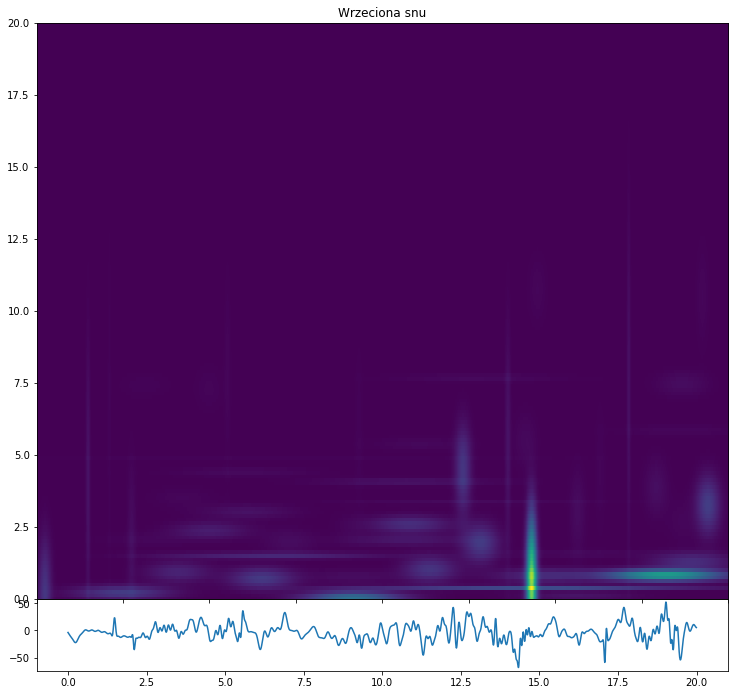

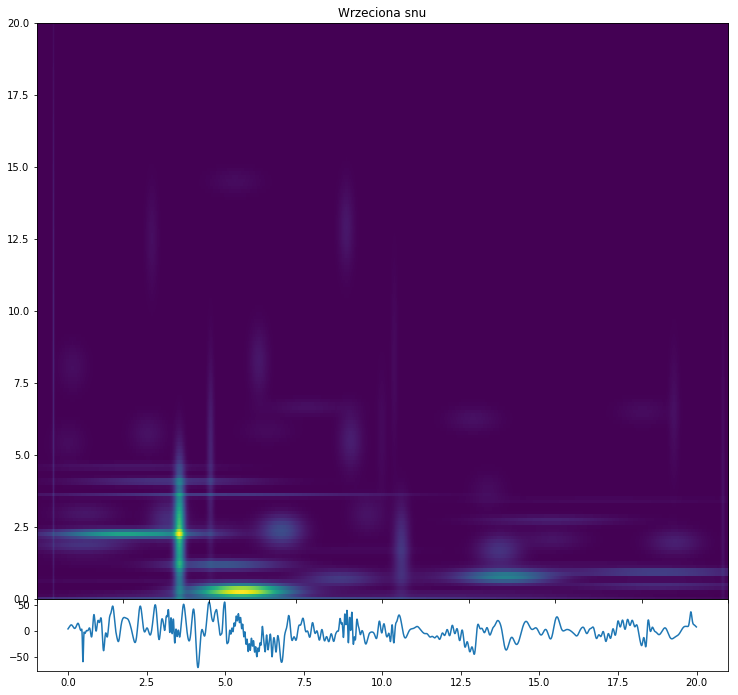

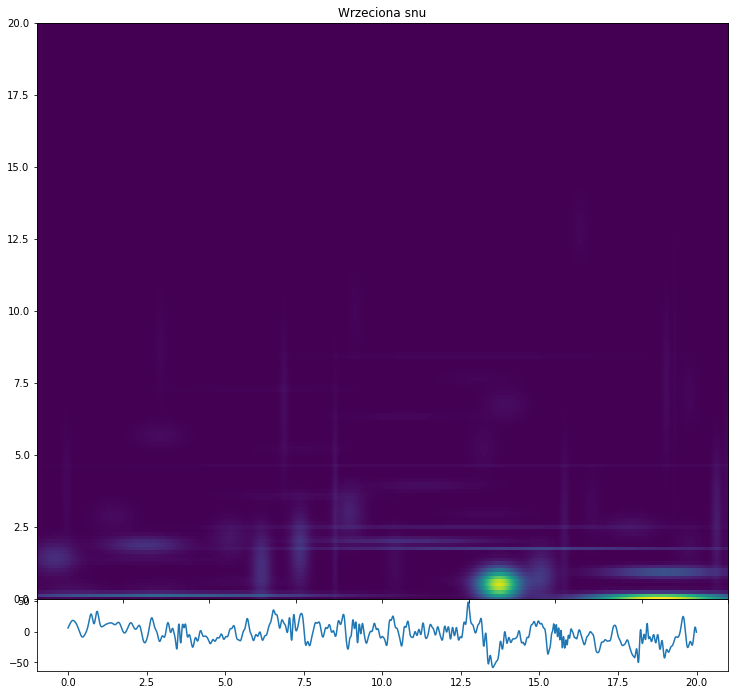

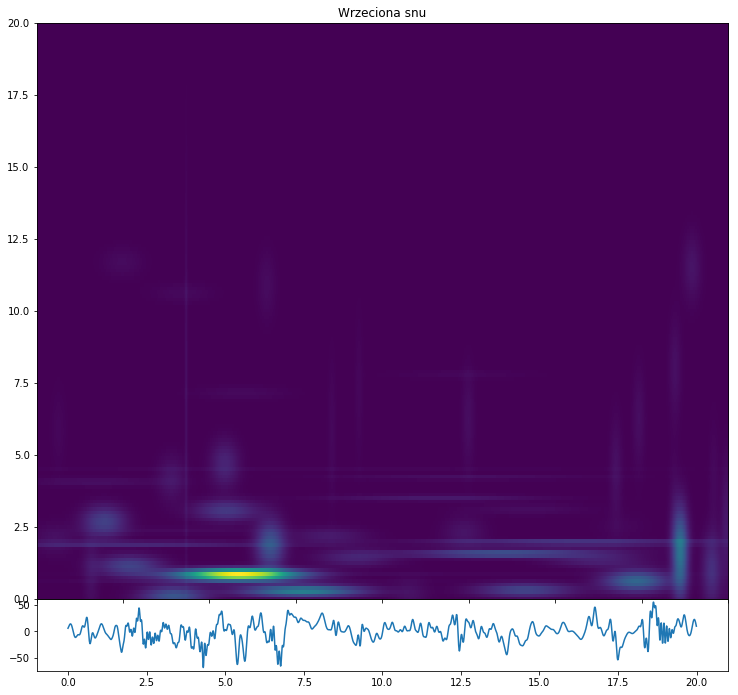

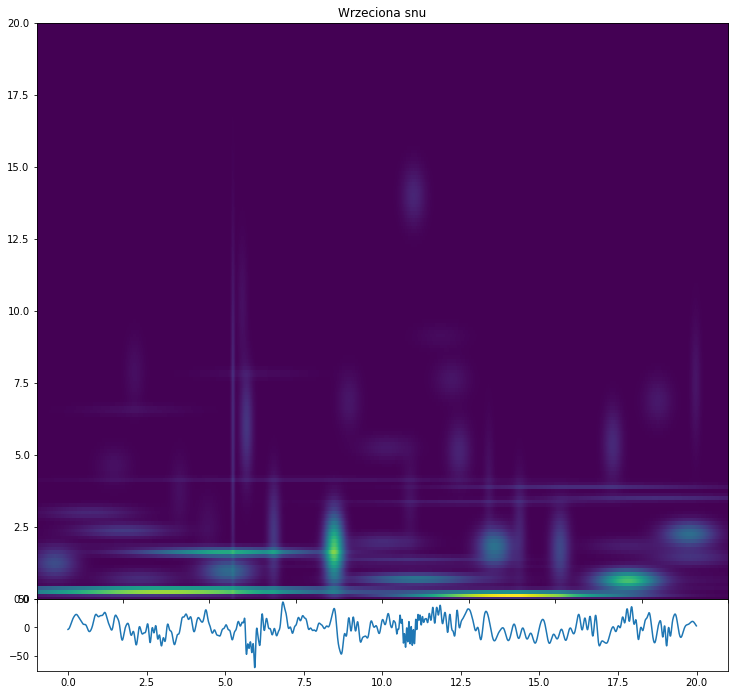

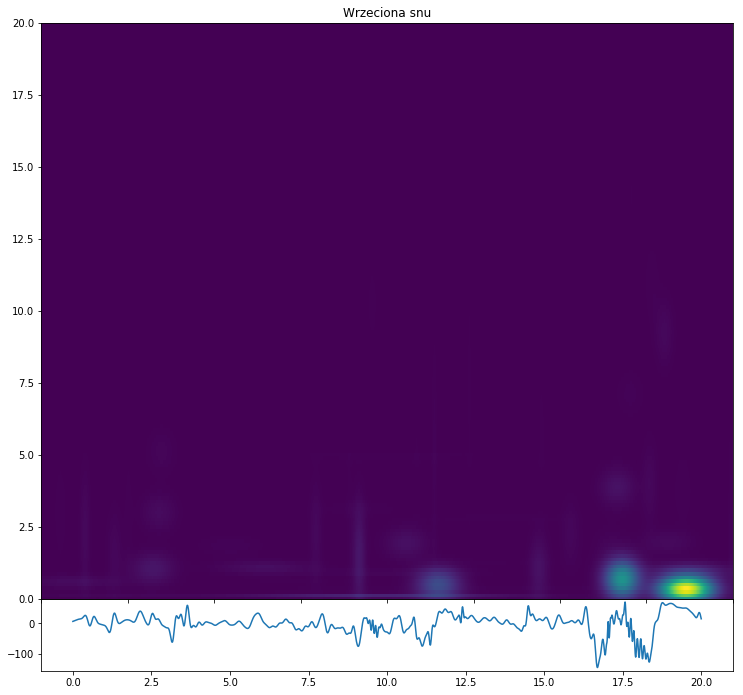

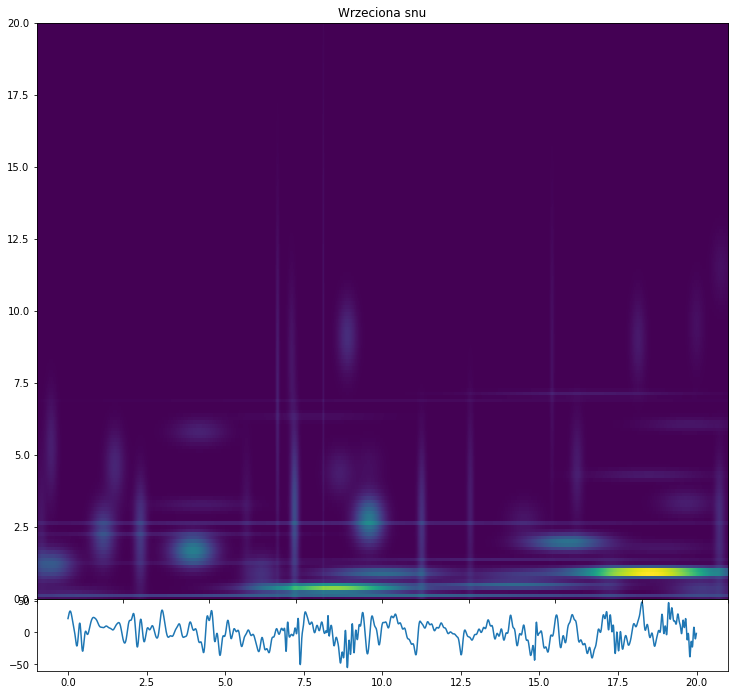

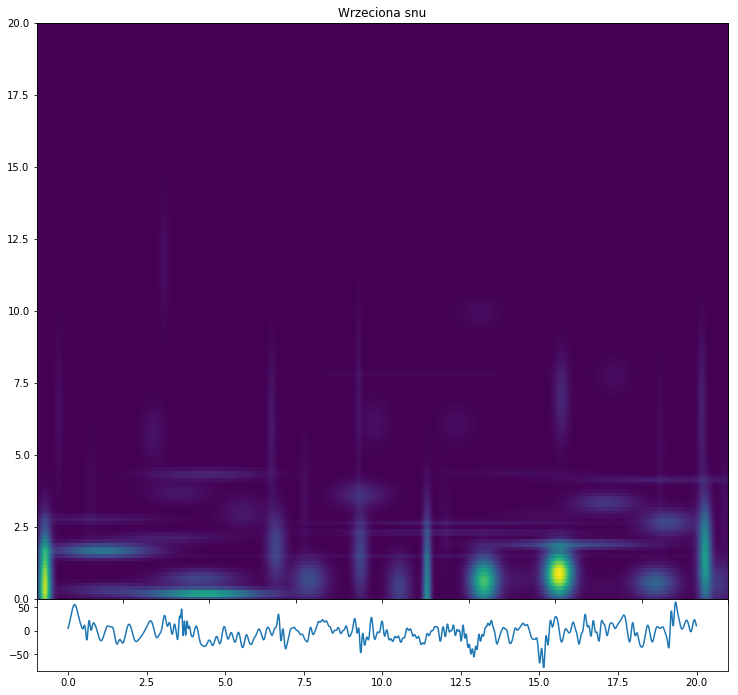

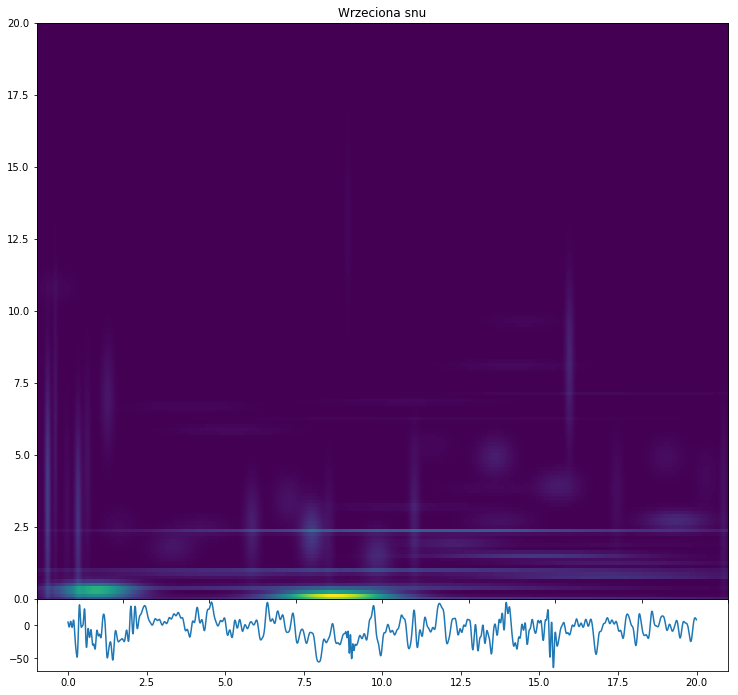

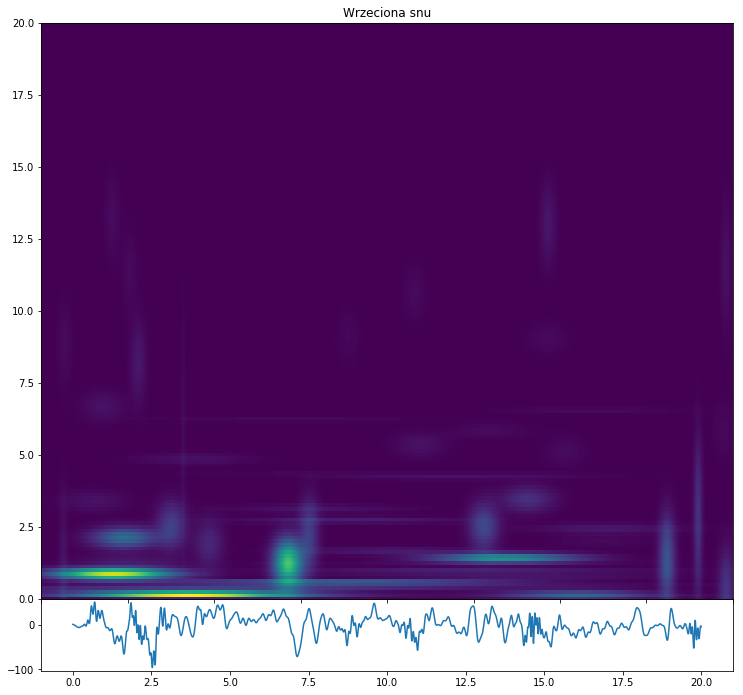

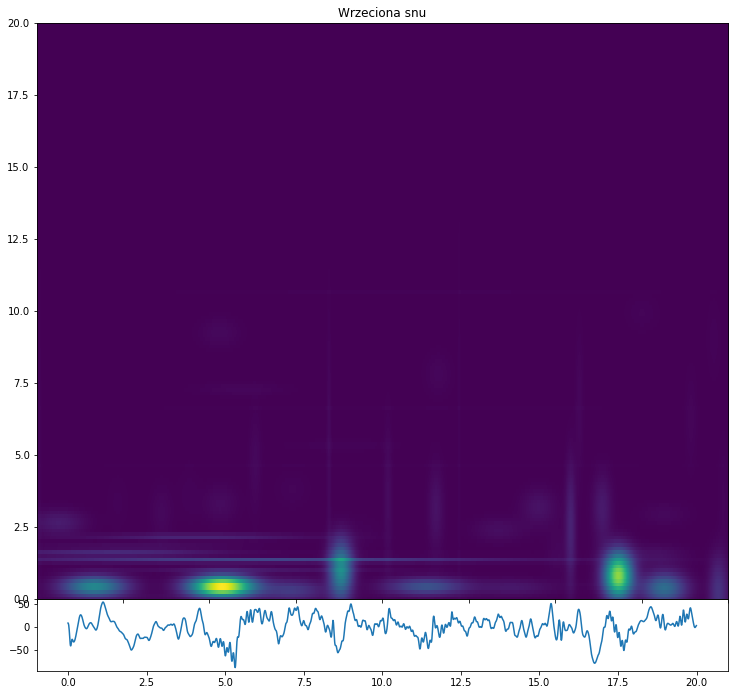

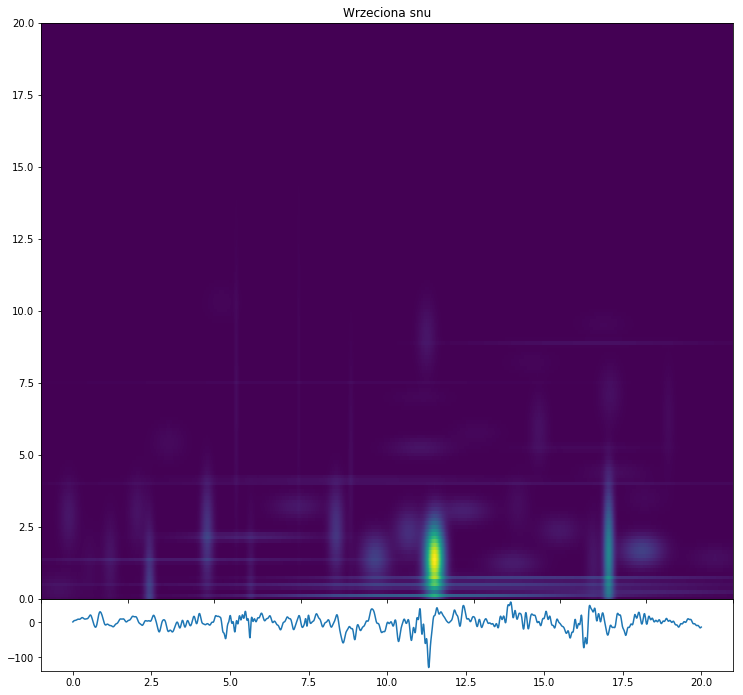

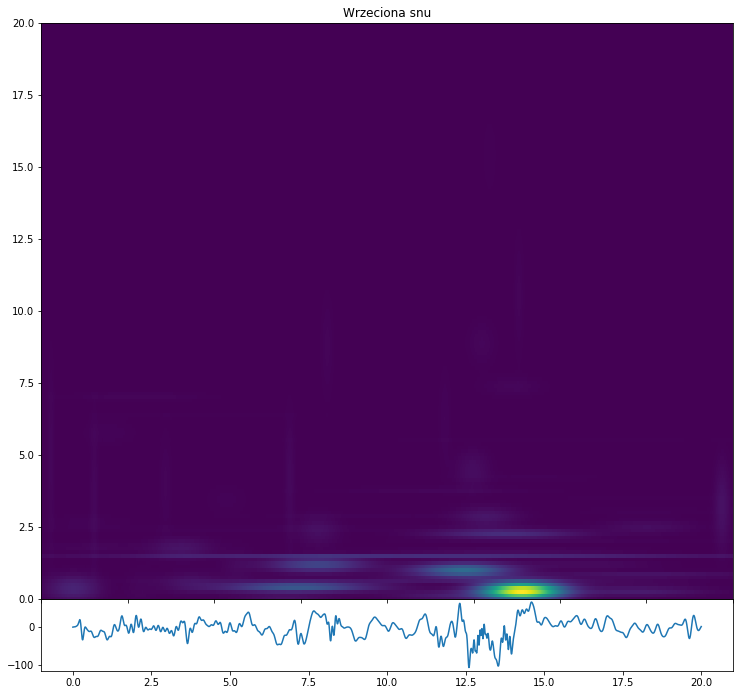

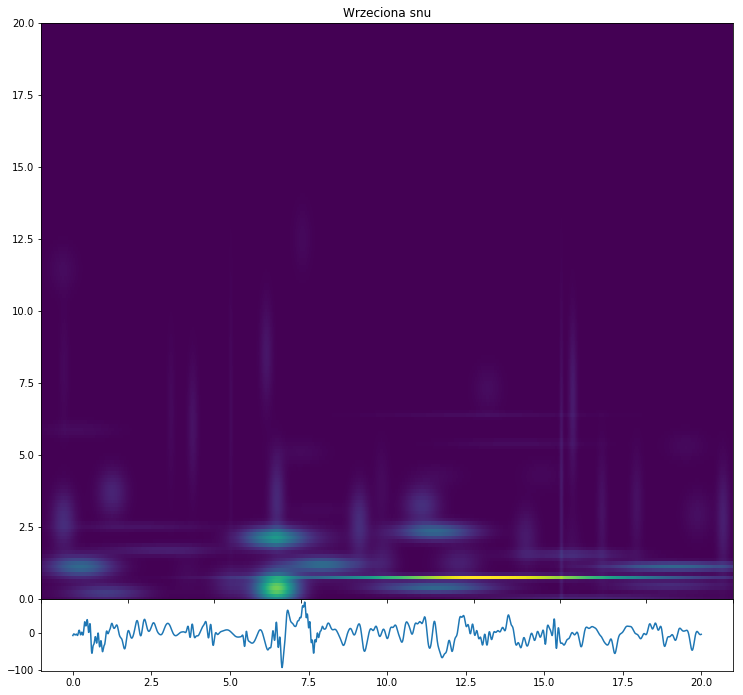

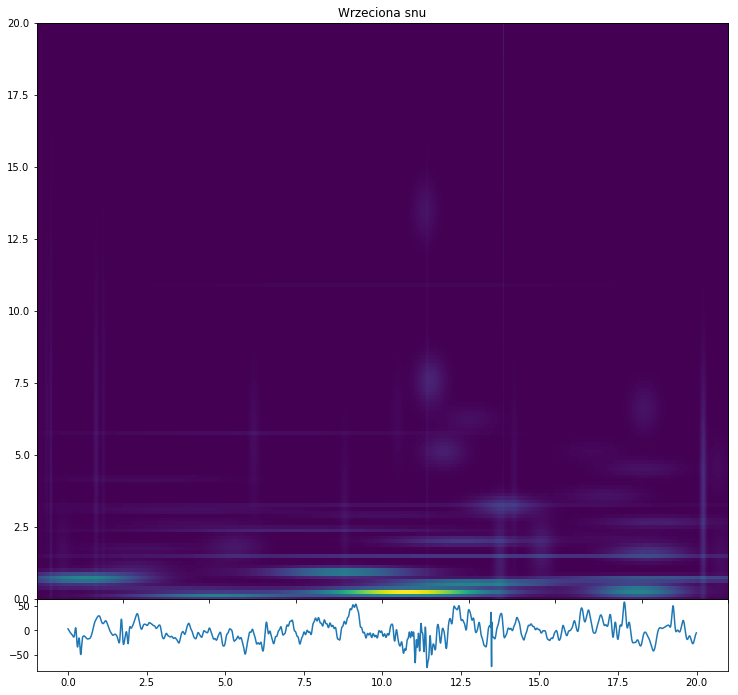

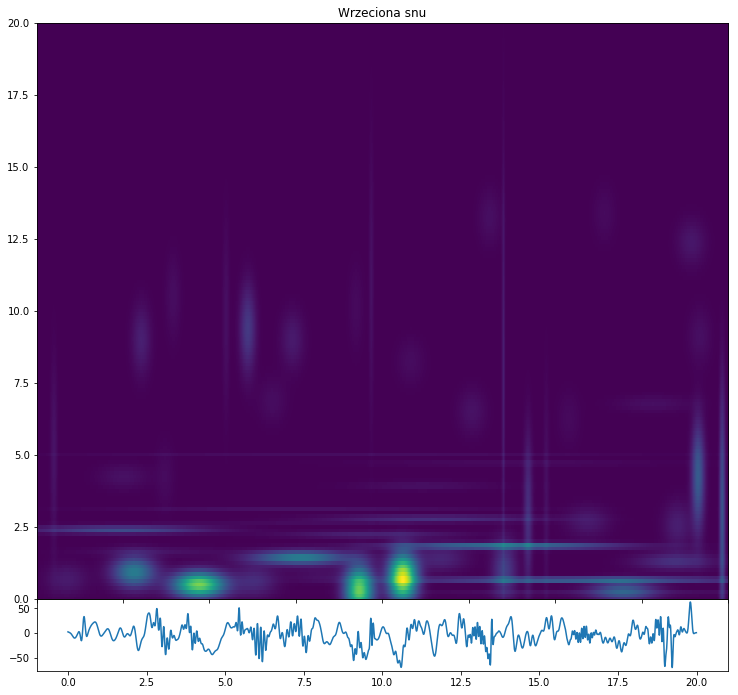

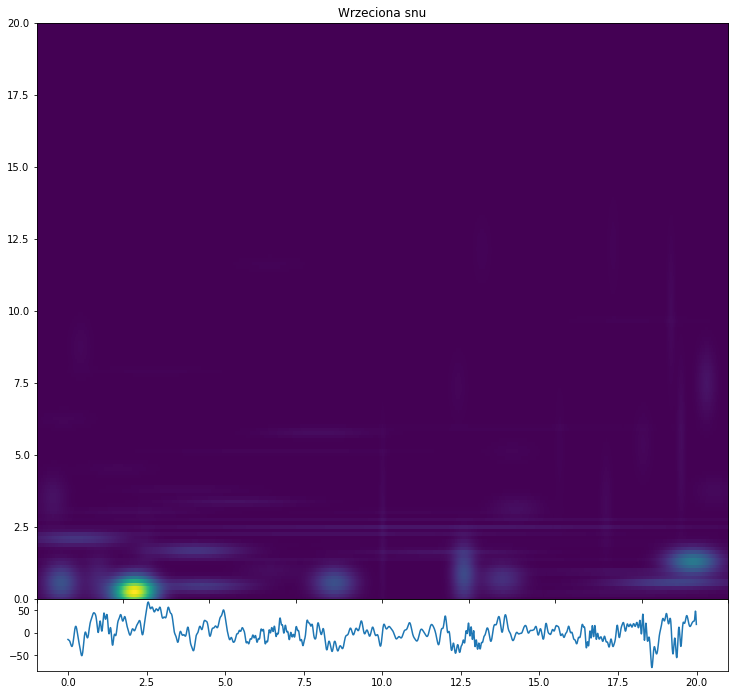

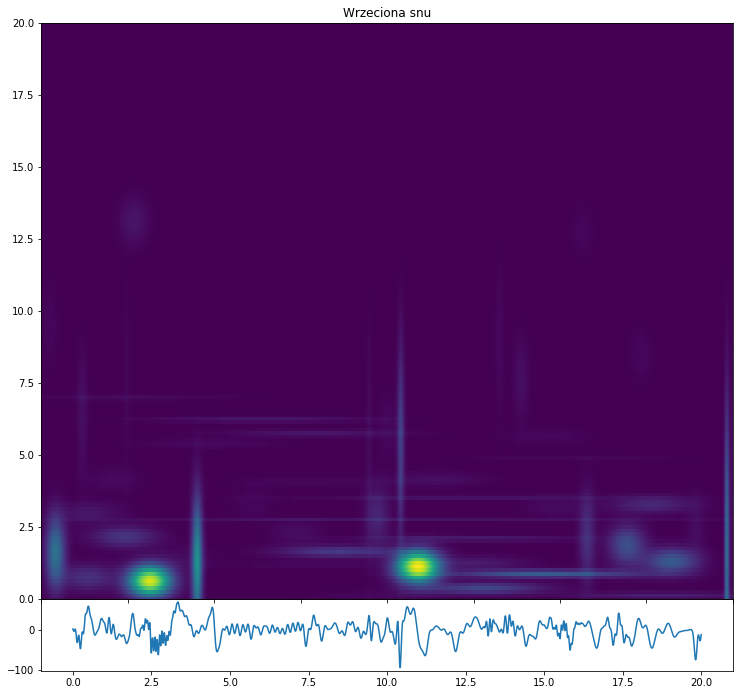

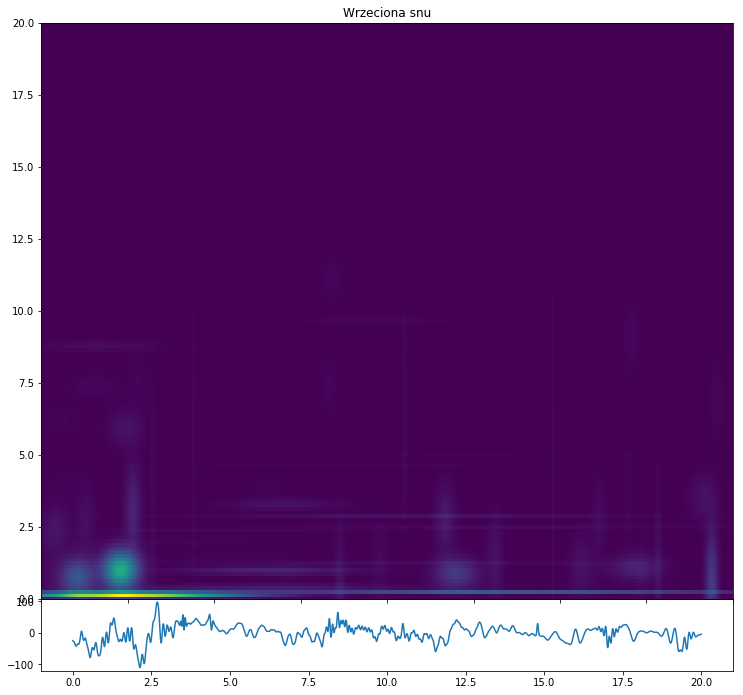

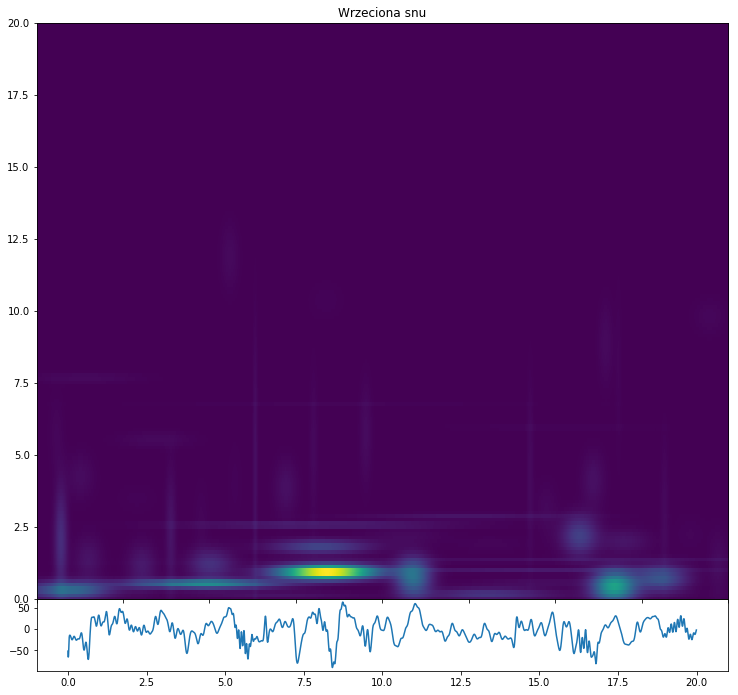

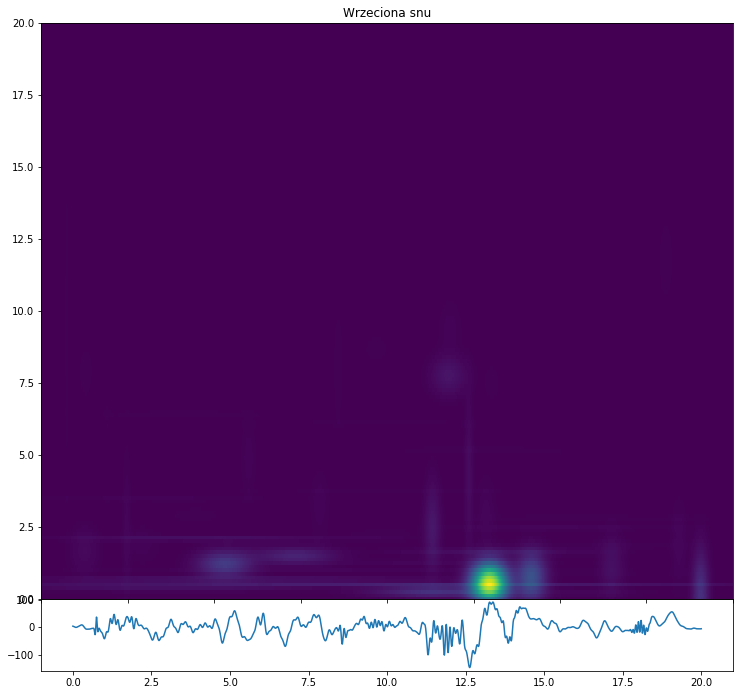

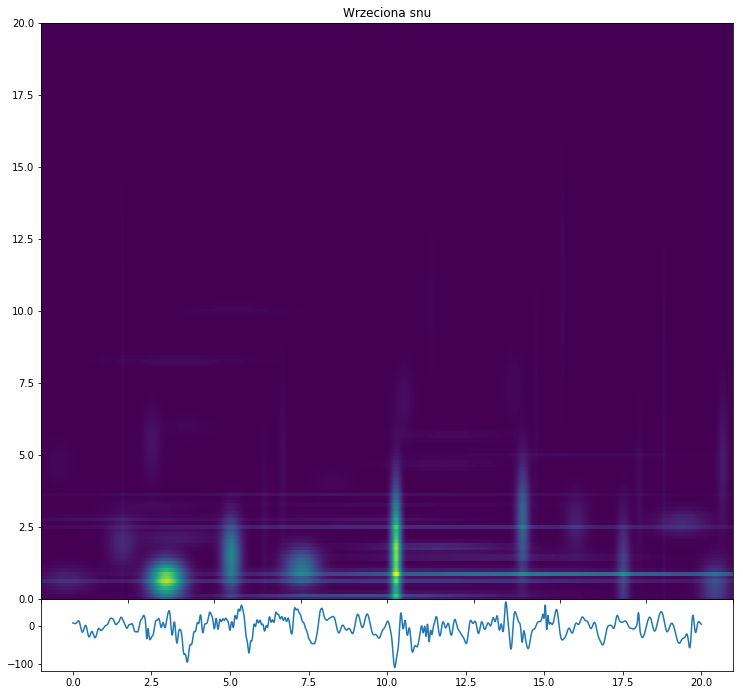

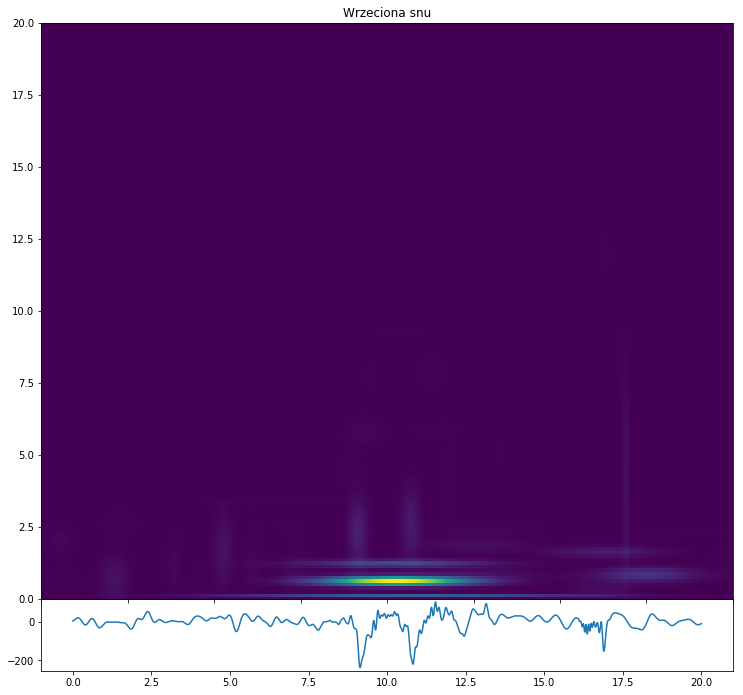

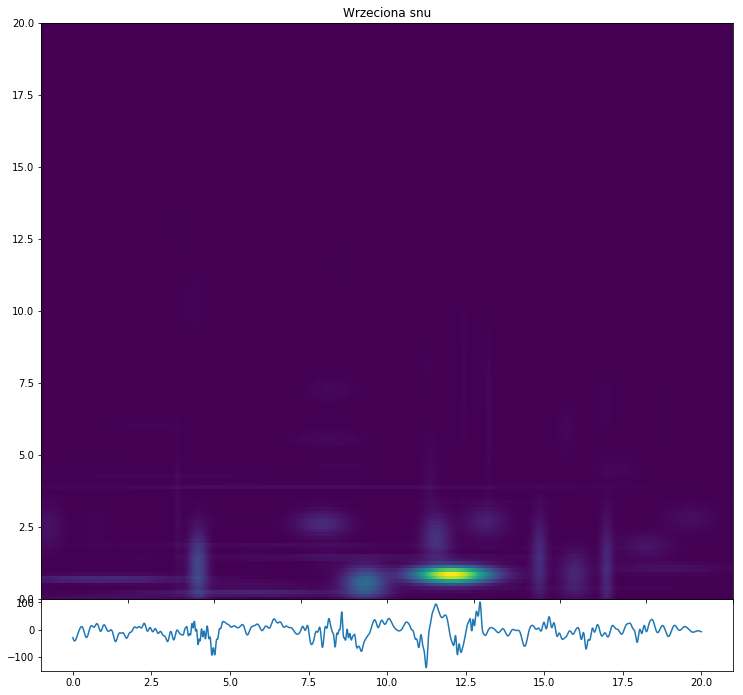

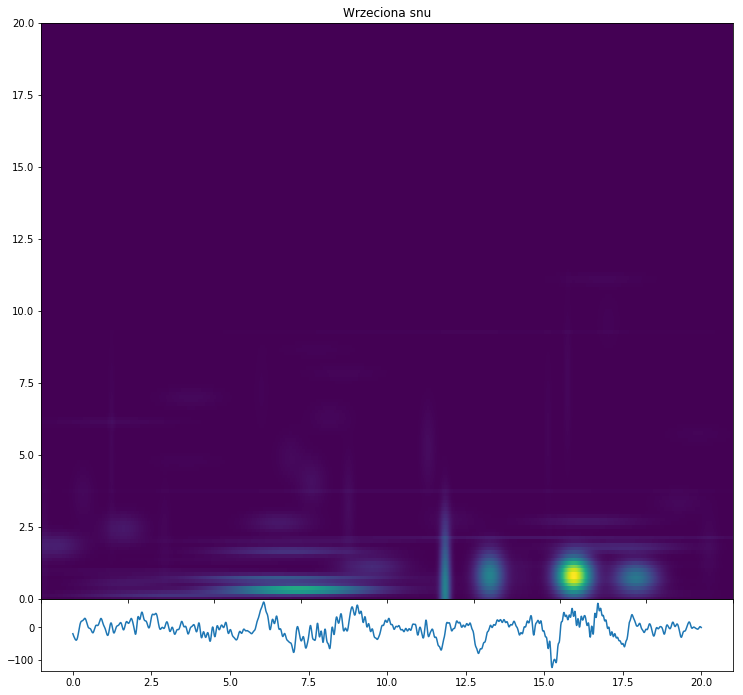

KeyboardInterrupt: 

In [33]:
from book_reader import *

for i in range(1,31): # iterujemy się po epokach:  
    bookName = 'inb14_fragment_smp_2.b'
    book = BookImporter(bookName)

    rekonstrukcja = np.zeros(book.epoch_s) # Przygotowujemy tablicę, w której powstanie rekonstrukcja.
    N_czestosci = 512
    mapaEnergii = np.zeros((N_czestosci, book.epoch_s)) # Przygotowujemy tablicę, w której powstanie reprezentacja czas-częstość.



    numerEpoki = i                                          # Posłuży on nam do odtwarzania poszczególnych atomów, liczymy je od 1, nie od 0 jak indeksy w Pythonie
    for atom in book.atoms[numerEpoki]:     # iterujemy się po atomach danej epoki
        f_Hz, A, faza, t0, skala  =  parametry_atomu(book, atom)
        t, atom_czas = rekonstrukcja_atomu(book, atom)
        t, f, atom_tfr = tfr_atomu (book, atom,N_czestosci)
        mapaEnergii += atom_tfr
        rekonstrukcja += atom_czas
        liczba_wrzecion +=1
    TFRPlot(mapaEnergii, t, f, rekonstrukcja, Fs=128,title ='Wrzeciona snu') 


In [50]:
przedzialy_czasowe_001=[] #dokładamy analogicznie jak w pierwszym klasyfikatorze
liczba_wrzecion_001=0

for i in range(1,31):
    bookName = 'inb14_fragment_smp_2.b'
    book = BookImporter(bookName)

    numerEpoki = i
    for atom in book.atoms[numerEpoki]:
        f_Hz, A, faza, t0, skala  = parametry_atomu(book, atom)
        if (f_Hz>=11)&(f_Hz<=14)&(skala*2>=0.5):
            liczba_wrzecion_001+=1
            przedzialy_czasowe_001.append(((i-1)*20 + t0, (i-1)*20 + t0 + skala)) #po 20s na epokę
print("Liczba wrzecion:", liczba_wrzecion_001)

Liczba wrzecion: 38


## Prezentacja wyników

Wrzeciona znalezione przy użyciu pierwszego klasyfikatora: 22


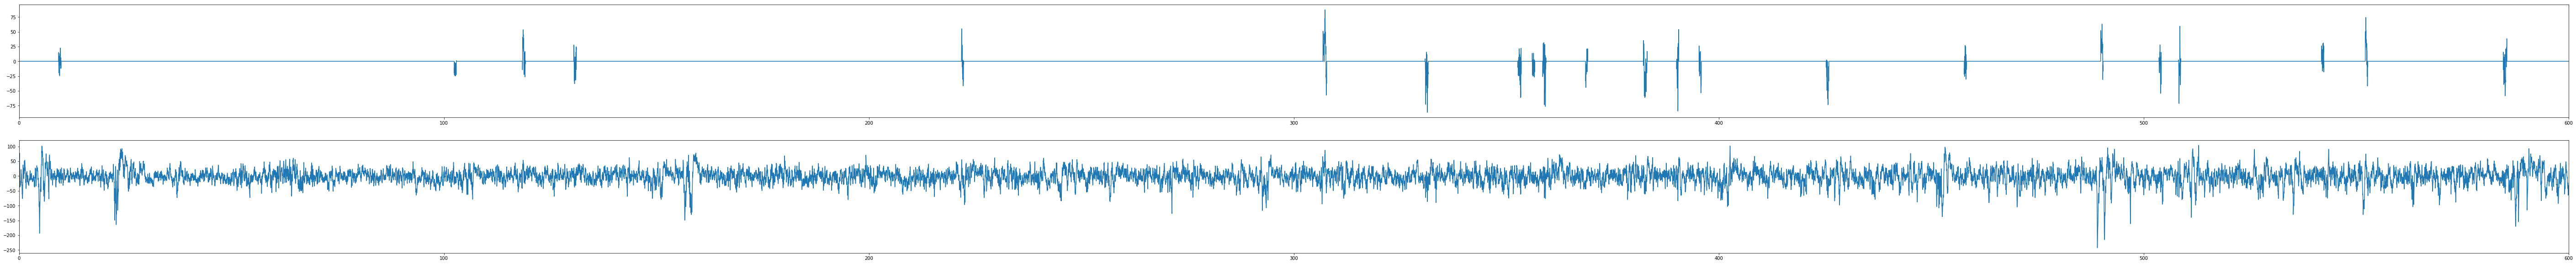

Wrzeciona znalezione przy użyciu drugiego klasyfikatora dla energyError=0.1: 27


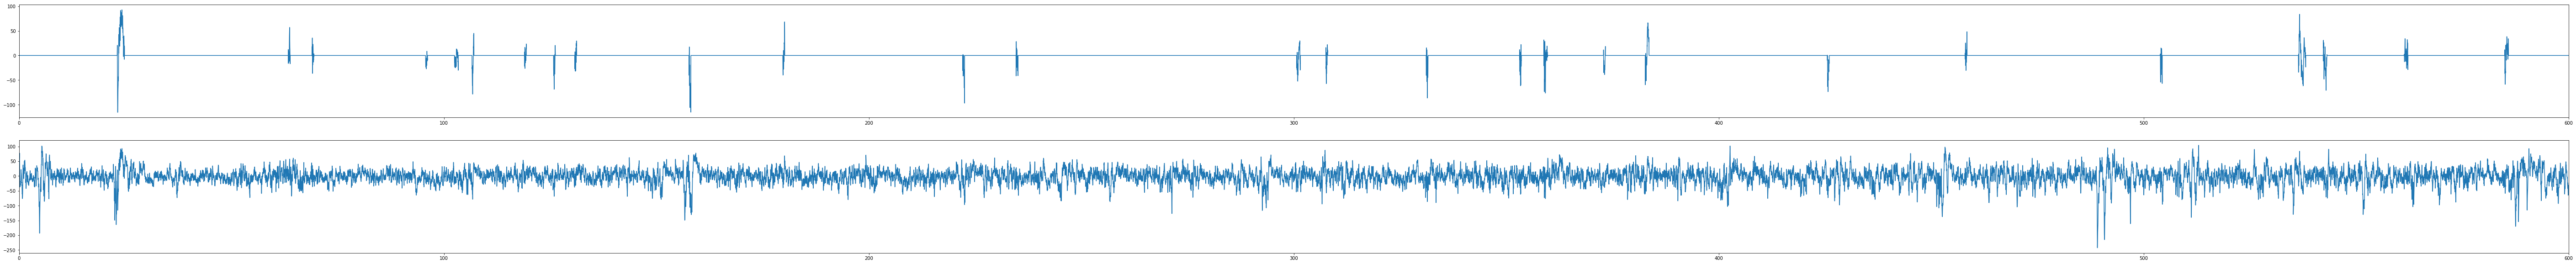

Wrzeciona znalezione przy użyciu drugiego klasyfikatora dla energyError=0.01: 38


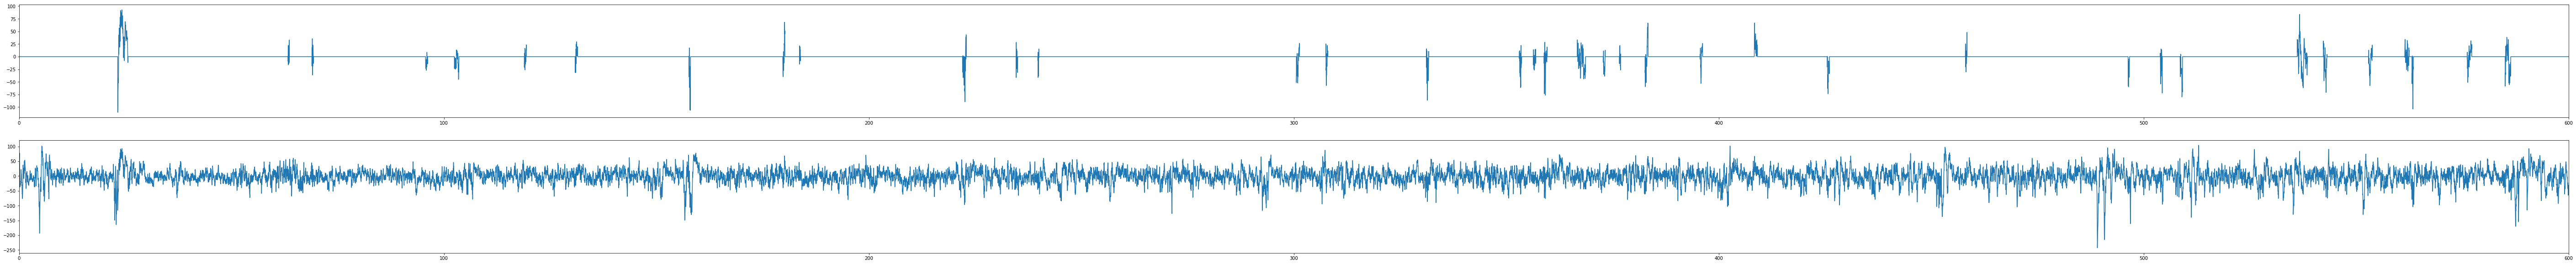

In [53]:
Fs=128
t=np.arange(0,600,1/Fs)

#Dla pierwszego klasyfikatora
klasyfikator_1 = np.zeros(len(signal))
for i in range (len(wrzeciona)):
     klasyfikator_1[wrzeciona[i][0]:wrzeciona[i][1]]+=s[wrzeciona[i][0]:wrzeciona[i][1]] #wybieram te fragmenty sygnału,gdzie wykryliśmy wrzeciona snu
        
print("Wrzeciona znalezione przy użyciu pierwszego klasyfikatora:", len(wrzeciona)) #rysuję znalezione wrzeciona oraz oryginalny sygnał dla porównania
plt.figure(figsize=(100,10))
plt.subplot(2,1,1)
plt.plot(t, klasyfikator_1)
plt.xlim(0,600)
plt.subplot(2,1,2)
plt.plot(t, s)
plt.xlim(0,600)
plt.show()

#energyError = 0.1
klasyfikator_2_01 = np.zeros(len(signal))
for i in range(len(przedzialy_czasowe)):
    klasyfikator_2_01[int(przedzialy_czasowe[i][0]*Fs):int(przedzialy_czasowe[i][1]*Fs)]+=s[int(przedzialy_czasowe[i][0]*Fs):int(przedzialy_czasowe[i][1]*Fs)]
    
print("Wrzeciona znalezione przy użyciu drugiego klasyfikatora dla energyError=0.1:", liczba_wrzecion)
plt.figure(figsize=(100,10))
plt.subplot(2,1,1)
plt.plot(t, klasyfikator_2_01)
plt.xlim(0,600)
plt.subplot(2,1,2)
plt.plot(t, s)
plt.xlim(0,600)
plt.show()

klasyfikator_2_001 = np.zeros(len(signal))
for i in range(len(przedzialy_czasowe_001)):
    klasyfikator_2_001[int(przedzialy_czasowe_001[i][0]*Fs):int(przedzialy_czasowe_001[i][1]*Fs)]+=s[int(przedzialy_czasowe_001[i][0]*Fs):int(przedzialy_czasowe_001[i][1]*Fs)]
    
print("Wrzeciona znalezione przy użyciu drugiego klasyfikatora dla energyError=0.01:", liczba_wrzecion_001)
plt.figure(figsize=(100,10))
plt.subplot(2,1,1)
plt.plot(t, klasyfikator_2_001)
plt.xlim(0,600)
plt.subplot(2,1,2)
plt.plot(t, s)
plt.xlim(0,600)
plt.show()


#### W jakich sytuacjach wskazania detektorów są zgodne a w jakich sprzeczne?

W tym przypadku uzyskałam zupełnie wyniki korzystając z każdego z detektorów, nie jestem w stanie więc stwierdzić, w jakich sytuacjach ich wskazania są zgodne. Na pewno widać, że dużo zależy od gęstości słownika ("energyError"), i im większa gęstość, tym lepsze wyniki. Za korzyść pierwszego klasyfikatora na pewno przemawia to, że pracyjemy na całym sygnale, bez dzielenia go na epoki, przez co nie narażamy się na utratę informacji np. poprzez pominięcie wrzeciona snu leżącego na granicy dwóch epok, czy podzielonego pomiędzy nie. 

Te same wrzeciona zostały wyłowione dla obu klasyfikatorów, w tych momentach sygnału, gdzie występują duże zmiany wartości, dlatego sądzę, że można założyć, że największą zgodność wyników uzyskamy dla jak największych amplitud fragmentów sygnałów będących wrzecionami snu.

#### W jaki sposób zgodność wyników zależy od wartości współczynnika "energyError".

"energyError" jest parametrem regulującym gęstość słownika na którym pracujemy - odpowiada minimalnej odległości między atomami słownika. Czym mniejsza wartość parametru, tym większa gęstość słownika, a co za tym idzie dokładniejsza kompozycja. Dlatego dla współczynnika "energyError" o wartości 0.01 znaleźliśmy prawie dwa razy więcej wrzecion, niż gdy jego wartość byla 10 razy większa - czyli gęstość słownika 10 razy mniejsza.

#### Własności zastosowanego filtra.

Przyfiltrowaniu sygnału na potrzeby pierwszego klasyfikatora stosowałam filtr butterwortha - możemy zobaczyć jego własności stosując odpowiednią funkcję, prezentującą charakterystyczne dla niego elementy.

In [30]:
from scipy.signal import buttord
from scipy.signal import freqz, group_delay

def charkterystyki(a,b,f,T,Fs):
    # przyda nam się oś czasu od -T do T sekund
    t = np.arange(-T, T, 1/Fs)
    
    # oś częstości przeliczamy na radiany
    omega = 2*np.pi* f/Fs
    
    # obliczamy transmitancję
    f, h = freqz(b, a=1, worN=f, whole=False, plot=None)
    
    # obliczamy moduł transmitancji
    m = np.abs(h)
        
    # obliczamy fazę i "rozwijamy" ją   
    faza = np.unwrap(np.angle(h)) # angle zwraca phi od -pi do pi, unwrap przekleja w krokach w pi (faza zawinieta -> faza ciągła)

    # obliczamy opóźnienie fazowe
    opoznienieFazowe = - faza/omega
    
    # obliczamy opóźnienie grupowe

    f_gr, grupowe = group_delay((b,a), f, Fs)
    
    # obliczamy odpowiedź impulsową
    x = np.zeros(len(t))
    x[len(t)//2] = 1 # impuls
    y = lfilter(b,a,x) # przepuszczamy impuls przez filtr i obserwujemy odpowiedź impulsową
    
    # obliczamy odpowiedź schodkową
    s = np.zeros(len(t))
    s[len(t)//2:] = 1 # schodek
    ys = lfilter(b,a,s) # przepuszczamy schodek przez filtr i obserwujemy odpowiedź schodkową
    
    # rysujemy
    fig = py.figure()
    py.subplot(2,2,1)
    py.title('moduł transmitancji')
    py.plot(f,20*np.log10(m))
    py.ylabel('[dB]')
    py.grid(True)
    
    #py.subplot(2,2,2)
    #py.title('opóźnienie fazowe')
    #py.plot(f, opoznienieFazowe)
    #py.ylabel('próbki')
    #py.grid(True)
    
    py.subplot(2,2,2)
    py.title('opóźnienie grupowe')
    py.plot(f_gr,grupowe)
    py.ylabel('próbki')
    py.xlabel('Częstość [Hz]')
    py.grid(True)
    py.ylim([0, np.max(grupowe)+1])
    
    py.subplot(2,2,3)
    py.title('odpowiedź impulsowa')
    py.plot(t, x)
    py.plot(t, y)
    py.xlim([-T/2,T])
    py.grid(True)
    
    py.subplot(2,2,4)
    py.title('odpowiedź schodkowa')
    py.plot(t, s)
    py.plot(t, ys)
    py.xlim([-T/2,T])
    py.xlabel('Czas [s]')
    py.grid(True)
    
    fig.subplots_adjust(hspace=.5)
    py.show()

C:\Users\weron\Anaconda3\lib\site-packages\scipy\signal\filter_design.py:685: UserWarning: The group delay is singular at frequencies [3.090, 3.100, 3.110, 3.120, 3.130, 3.140, 3.150, 3.160, 3.170, 3.180, 3.190, 9.370, 9.380, 9.390, 9.400, 9.410, 9.420, 9.430, 9.440, 9.450, 9.460, 9.470, 9.480, 15.660, 15.670, 15.680, 15.690, 15.700, 15.710, 15.720, 15.730, 15.740, 15.750, 15.760, 21.940, 21.950, 21.960, 21.970, 21.980, 21.990, 22.000, 22.010, 22.020, 22.030, 22.040, 28.220, 28.230, 28.240, 28.250, 28.260, 28.270, 28.280, 28.290, 28.300, 28.310, 28.320, 28.330, 34.510, 34.520, 34.530, 34.540, 34.550, 34.560, 34.570, 34.580, 34.590, 34.600, 34.610, 40.790, 40.800, 40.810, 40.820, 40.830, 40.840, 40.850, 40.860, 40.870, 40.880, 40.890, 47.070, 47.080, 47.090, 47.100, 47.110, 47.120, 47.130, 47.140, 47.150, 47.160, 47.170, 47.180, 53.360, 53.370, 53.380, 53.390, 53.400, 53.410, 53.420, 53.430, 53.440, 53.450, 53.460, 59.640, 59.650, 59.660, 59.670, 59.680, 59.690, 59.700, 59.710, 59.720, 

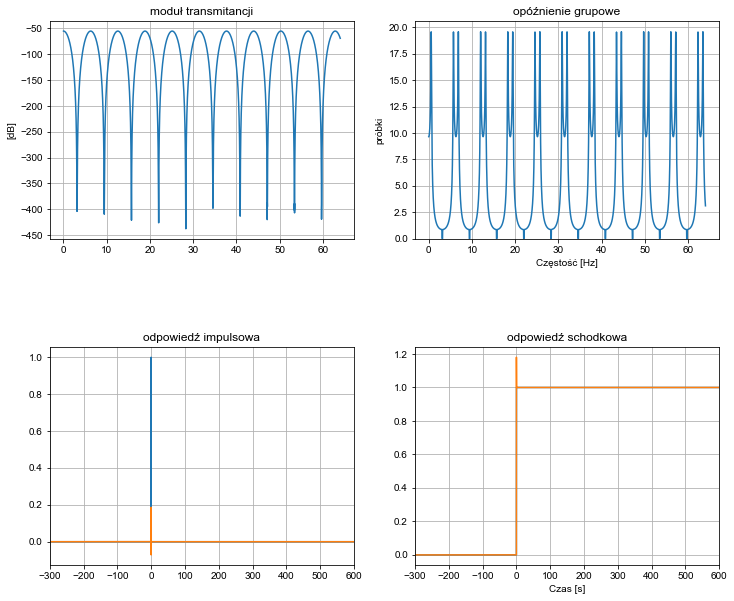

Użyty filtr Butterwortha, rząd filtra: 9, częstość odcięcia dla danego filtra 11.812


In [33]:
f = np.arange(0.01,Fs/2,0.01) 

wp = 11/(Fs/2)
ws = 16/(Fs/2)
gpass = 1
gstop = 25
analog=0
rp = gpass
rs = gstop

[n,Wn]=buttord(wp, ws, gpass, gstop)
[b,a]=butter(n,Wn)
charkterystyki(a,b,f,T = 600,Fs=128)

print('Użyty filtr Butterwortha, rząd filtra: {}, częstość odcięcia dla danego filtra {:.3f}'.format(n,Wn*Fs/2))